# The Impact of Gun Laws on Homicide Rates in the United States
[Gifford's Law Center](https://lawcenter.giffords.org) is a non-profit organizaton whose mission is to reduce gun violence. They provide [annual rankings](https://lawcenter.giffords.org/scorecard/) of state gun laws and measure the rankings against gun homicide rates. A counter-argument made against such results is that, while gun homicide deaths may decrease, the rate of homicides by other means will increase as a result. Here, we will test that theory by first quantifying the results of the Gifford Law Center, then use the grades to see if the results hold true when accounting for homicide rates without guns. If the correlation between strength of gun laws and non-firearm homicide rates is negative, while the correlation with firearm homicide rates is positive, it will lend credence to the arguments made by gun rights activists.

## Scrape Data from Giffords Law Center
The site contains a table of rankings by state, including a gun death rate per 100k people. We will grab 2018 data from this table and parse it into a dataframe. In addition, grades will be translated to a traditional grade points scale so that correlation and p-values can be calculated later.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

from bs4 import BeautifulSoup
import requests

# url = 'https://lawcenter.giffords.org/scorecard/#rankings'

# #Make a get request to retrieve the page
# html_page = requests.get(url) 

# #Pass the page contents to beautiful soup for parsing
# soup = BeautifulSoup(html_page.content, 'html.parser') 

# # States use the 'strong' tag
# tables = soup.find_all('table')

In [2]:
# # Create Dictionary for parsing values
# state_rankings_2018 = {'Year': [], 'State':[], 'Grade': [], 'State_GPA': [], 'Gun_Death_Rate': []}

# # Define grading scale
# grades = {'A':4, 'A-': 3.7, 
#           'B+': 3.3, 'B': 3, 'B-':2.7, 
#           'C+': 2.3, 'C': 2, 'C-': 1.7, 
#           'D+': 1.3, 'D': 1, 'D-': .7, 'F': 0}

# # Iterate through each row of table and save to dictionary
# for i in range(50):
#     state_rankings_2018['Year'].append(2017)
#     state_rankings_2018['State'].append(tables[0].find_all('td')[5 * i + 1].text)
#     state_rankings_2018['Grade'].append(tables[0].find_all('td')[5 * i + 2].text)
#     state_rankings_2018['State_GPA'].append(grades[state_rankings_2018['Grade'][-1]])
#     state_rankings_2018['Gun_Death_Rate'].append(float(tables[0].find_all('td')[5 * i + 4].text))

# # Create dataframe from dictionary
# pd.DataFrame.from_dict(state_rankings_2018).to_csv('giffords/giffords_2018.csv')

# Preview dataframe
giffords_df_2018 = pd.read_csv('giffords/giffords_2018.csv', index_col=0)
giffords_df_2018.head()

,Year,State,Grade,State_GPA,Gun_Death_Rate
0,2017,Alabama,F,0.0,22.9
1,2017,Alaska,F,0.0,24.5
2,2017,Arizona,F,0.0,15.7
3,2017,Arkansas,F,0.0,20.2
4,2017,California,A,4.0,7.8


### Quantify and Visualize Results

R-Square: 0.6207020030717032
Intercept: 17.318130935828243
Slope: -2.9352862159168582
P-Value: 1.129765290532049e-11


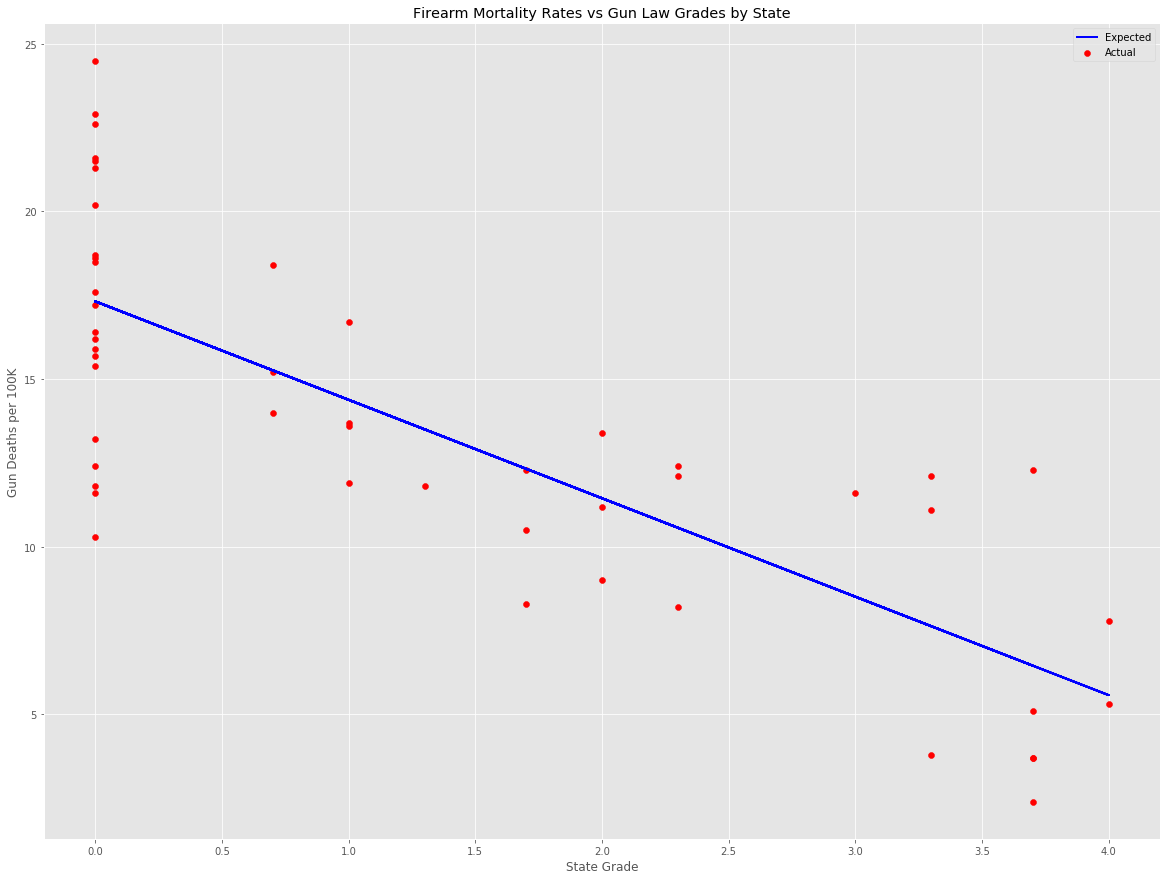

In [3]:
import statsmodels.formula.api as smf
import sklearn as sk
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

plt.style.use('ggplot')

f = 'Gun_Death_Rate~State_GPA'
model = smf.ols(formula=f, data=giffords_df_2018).fit()

print(f'R-Square: {model.rsquared}') 
print(f'Intercept: {model.params[0]}')
print(f'Slope: {model.params[1]}')
print(f'P-Value: {model.pvalues[1]}')

y_pred = model.predict()
plt.figure(figsize=(20, 15))
plt.title('Firearm Mortality Rates vs Gun Law Grades by State')
plt.xlabel('State Grade')
plt.ylabel('Gun Deaths per 100K')
plt.scatter(giffords_df_2018['State_GPA'], giffords_df_2018['Gun_Death_Rate'], marker='o', label='Actual', color='r')
plt.plot(giffords_df_2018['State_GPA'], y_pred, color='b', lw=2, label='Expected')
plt.legend()
plt.show()

It is clear that a negative correlation exists between the strength of gun laws and the number of firearm-related deaths. However, an R-Square value of 0.62 indicates that the strength of laws only account for 62% of the variation in gun homicide rates. The implication is that the effectiveness of gun laws on gun homicide rates is limited.

## Homicides without Firearms
Age- and population-standardized rates for 2014 - 2017 can be accessed from the CDC's [National Center for Health Statistics](https://www.cdc.gov/nchs/pressroom/sosmap/homicide_mortality/homicide.htm). Similar data can be found for homicide rates with firearms for the same time periods from the [same source](https://www.cdc.gov/nchs/pressroom/sosmap/firearm_mortality/firearm.htm). 

**Standardization Notes:** Homicides occur at greater rates in more population dense regions and among younger generations. If a particular state has an older population and is more rural, it is expected to have lower homicide rates irregardless of the laws in place. By standardizing age and population rates, results can be compared more accurately across time and regions. It is unknown whether or not the Giffords Law Institute has accounted for such variation in their calculated homicide rates with firearms.

In [4]:
cats = ['homicide', 'suicide']

def get_cdc_data(cat):
    cols = ['State', 'Year', 'Deaths', 'Population', 'Age Adjusted Rate']

    a = f'cdc_data/{cat}/all_1979-1998.txt'
    b = f'cdc_data/{cat}/all_1999-2016.txt'
    gun_a = f'cdc_data/{cat}/firearm_1979-1998.txt'
    gun_b = f'cdc_data/{cat}/firearm_1999-2016.txt'
    
    
    df_a = pd.read_csv(a, sep='\t', usecols=cols).dropna()
    df_b = pd.read_csv(b, sep='\t', usecols=cols).dropna()
    gun_df_a = pd.read_csv(gun_a, sep='\t', usecols=cols).dropna()
    gun_df_b = pd.read_csv(gun_b, sep='\t', usecols=cols).dropna()
    
    df = df_a.append(df_b).reset_index(drop=True)
    gun_df = gun_df_a.append(gun_df_b).reset_index(drop=True)
    
    cat_col = f'{cat.title()} Rate'
    df = df.rename(columns={'Age Adjusted Rate': cat_col})
    df[cat_col] = df[cat_col].astype('str')
    df['Year'] = df['Year'].astype('int')
    df = df[df.Year>=1991].reset_index(drop=True)
    df['Deaths'] = df['Deaths'].replace('Suppressed', '10').astype('int')
    df['State-Year'] = df['State'] + ' ' + df['Year'].astype('str')
    df = df.set_index('State-Year')
    
    gun_cat_col = f'Gun {cat.title()} Rate'
    gun_df = gun_df.rename(columns={'Age Adjusted Rate': gun_cat_col})
    gun_df[gun_cat_col] = gun_df[gun_cat_col].astype('str')
    gun_df['Year'] = gun_df['Year'].astype('int')
    gun_df = gun_df[gun_df.Year>=1991].reset_index(drop=True)
    gun_df['Deaths'] = gun_df['Deaths'].replace('Suppressed', '10').astype('int')
    gun_df['State-Year'] = gun_df['State'] + ' ' + gun_df['Year'].astype('str')
    gun_df = gun_df.set_index('State-Year')
    
    for ix in df.index:
        if ('Unreliable' in df.loc[ix, cat_col]) or (df.loc[ix, cat_col] == 'Suppressed'):
            deaths = df.loc[ix, 'Deaths']
            pop = df.loc[ix, 'Population']
            df.loc[ix, cat_col] = np.round(100000 * deaths/pop, 1)
            
    for ix in gun_df.index:
        if ('Unreliable' in gun_df.loc[ix, gun_cat_col]) or (gun_df.loc[ix, gun_cat_col] == 'Suppressed'):
            deaths = gun_df.loc[ix, 'Deaths']
            pop = gun_df.loc[ix, 'Population']
            gun_df.loc[ix, gun_cat_col] = np.round(100000 * deaths/pop, 1)
    
    final_df = df.join(gun_df[gun_cat_col]).drop(['Deaths', 'Population'], axis=1)
    for col in [cat_col, gun_cat_col]:
        final_df[col] = final_df[col].astype('float')
        
    final_df[f'Other {cat.title()}'] = final_df[cat_col] - final_df[gun_cat_col]
    final_df[f'{cat.title()} Pct Difference'] = final_df[f'Other {cat.title()}'] / final_df[gun_cat_col]
    return final_df

In [5]:
homicide_df = get_cdc_data('homicide')
suicide_df = get_cdc_data('suicide')
gun_mortality_df = homicide_df.join(suicide_df[suicide_df.columns[2:]])
gun_mortality_df.head()

,State,Year,Homicide Rate,Gun Homicide Rate,Other Homicide,Homicide Pct Difference,Suicide Rate,Gun Suicide Rate,Other Suicide,Suicide Pct Difference
State-Year,,,,,,,,,,
Alabama 1991,Alabama,1991,13.8,10.0,3.8,0.380000,13.2,10.4,2.8,0.269231
Alabama 1992,Alabama,1992,12.7,9.1,3.6,0.395604,12.6,9.5,3.1,0.326316
Alabama 1993,Alabama,1993,13.4,9.5,3.9,0.410526,13.0,10.1,2.9,0.287129
Alabama 1994,Alabama,1994,13.7,9.9,3.8,0.383838,12.6,9.4,3.2,0.340426
Alabama 1995,Alabama,1995,12.0,9.1,2.9,0.318681,13.0,9.9,3.1,0.313131


In [6]:
cols = ['State', 'Year', 'Deaths', 'Population', 'Age Adjusted Rate']

accident_a = pd.read_csv('cdc_data/accidents/firearm_1979-1998.txt', sep='\t', usecols=cols).dropna()
accident_b = pd.read_csv('cdc_data/accidents/firearm_1999-2016.txt', sep='\t', usecols=cols).dropna()
accident_df = accident_a.append(accident_b)

accident_df = accident_df.rename(columns={'Age Adjusted Rate': 'Gun Accident Rate'})
accident_df['Year'] = accident_df['Year'].astype('int')
accident_df = accident_df[accident_df.Year>=1991].reset_index(drop=True)

accident_df['Deaths'] = accident_df['Deaths'].replace('Suppressed', '10').astype('int')
accident_df['State-Year'] = accident_df['State'] + ' ' + accident_df['Year'].astype('str')
accident_df = accident_df.set_index('State-Year')

for ix in accident_df.index:
    if ('Unreliable' in accident_df.loc[ix, 'Gun Accident Rate']) or (accident_df.loc[ix, 'Gun Accident Rate'] == 'Suppressed'):
        deaths = accident_df.loc[ix, 'Deaths']
        pop = accident_df.loc[ix, 'Population']
        accident_df.loc[ix, 'Gun Accident Rate'] = np.round(100000 * deaths/pop, 1)

accident_df['Gun Accident Rate'] = accident_df['Gun Accident Rate'].astype('float')

gun_mortality = gun_mortality_df.join(accident_df['Gun Accident Rate'])
gun_mortality.head()

,State,Year,Homicide Rate,Gun Homicide Rate,Other Homicide,Homicide Pct Difference,Suicide Rate,Gun Suicide Rate,Other Suicide,Suicide Pct Difference,Gun Accident Rate
State-Year,,,,,,,,,,,
Alabama 1991,Alabama,1991,13.8,10.0,3.8,0.380000,13.2,10.4,2.8,0.269231,1.5
Alabama 1992,Alabama,1992,12.7,9.1,3.6,0.395604,12.6,9.5,3.1,0.326316,1.7
Alabama 1993,Alabama,1993,13.4,9.5,3.9,0.410526,13.0,10.1,2.9,0.287129,2.0
Alabama 1994,Alabama,1994,13.7,9.9,3.8,0.383838,12.6,9.4,3.2,0.340426,1.8
Alabama 1995,Alabama,1995,12.0,9.1,2.9,0.318681,13.0,9.9,3.1,0.313131,1.9


## Law Grades 2014-2017
The Gifford's Law Center provides historical grades and rankings for prior years as well, and this can be used to compare against CDC data. The 2014 table is laid out slightly differently, so requires a separate pass of the data from other years.

In [7]:
# # Get results for all other years
# state_rankings = {'Year':[], 'State':[], 'Grade':[], 'State Grade':[]}

# for yr in range(2015, 2018):
#     url = f'https://lawcenter.giffords.org/scorecard{int(yr)}/#rankings'

#     #Make a get request to retrieve the page
#     html_page = requests.get(url) 

#     #Pass the page contents to beautiful soup for parsing
#     soup = BeautifulSoup(html_page.content, 'html.parser') 

#     # States use the 'strong' tag
#     tables = soup.find_all('table')

#     # Define grading scale
#     grades = {'A':4, 'A-': 3.7, 
#               'B+': 3.3, 'B': 3, 'B-':2.7, 
#               'C+': 2.3, 'C': 2, 'C-': 1.7, 
#               'D+': 1.3, 'D': 1, 'D-': .7, 'F': 0}

#     # Iterate through each row of table and save to dictionary
#     for i in range(50):
#         state_rankings['Year'].append(yr-1)
#         state_rankings['State'].append(tables[0].find_all('td')[5 * i + 1].text.strip())
#         state_rankings['Grade'].append(tables[0].find_all('td')[5 * i + 2].text.strip())
#         state_rankings['State Grade'].append(grades[state_rankings['Grade'][-1]])

# # Create dataframe from dictionary
# pd.DataFrame.from_dict(state_rankings).to_csv('giffords/giffords.csv')


giffords_df = pd.read_csv('giffords/giffords.csv', index_col=0)
giffords_df['State-Year'] = giffords_df.State + ' ' + giffords_df.Year.astype('str')
giffords_df = giffords_df.set_index('State-Year').sort_index()
giffords_df.head(15)

,Year,State,Grade,State Grade
State-Year,,,,
Alabama 2014,2014,Alabama,F,0.0
Alabama 2015,2015,Alabama,F,0.0
Alabama 2016,2016,Alabama,F,0.0
Alaska 2014,2014,Alaska,F,0.0
Alaska 2015,2015,Alaska,F,0.0
Alaska 2016,2016,Alaska,F,0.0
Arizona 2014,2014,Arizona,F,0.0
Arizona 2015,2015,Arizona,F,0.0
Arizona 2016,2016,Arizona,F,0.0


### State Name/Abbreviation Mapping

In [8]:
state_abbrs = {
            'AK': 'Alaska',
            'AL': 'Alabama',
            'AR': 'Arkansas',
            'AS': 'American Samoa',
            'AZ': 'Arizona',
            'CA': 'California',
            'CO': 'Colorado',
            'CT': 'Connecticut',
            'DC': 'District of Columbia',
            'DE': 'Delaware',
            'FL': 'Florida',
            'GA': 'Georgia',
            'GU': 'Guam',
            'HI': 'Hawaii',
            'IA': 'Iowa',
            'ID': 'Idaho',
            'IL': 'Illinois',
            'IN': 'Indiana',
            'KS': 'Kansas',
            'KY': 'Kentucky',
            'LA': 'Louisiana',
            'MA': 'Massachusetts',
            'MD': 'Maryland',
            'ME': 'Maine',
            'MI': 'Michigan',
            'MN': 'Minnesota',
            'MO': 'Missouri',
            'MP': 'Northern Mariana Islands',
            'MS': 'Mississippi',
            'MT': 'Montana',
            'NA': 'National',
            'NC': 'North Carolina',
            'ND': 'North Dakota',
            'NE': 'Nebraska',
            'NH': 'New Hampshire',
            'NJ': 'New Jersey',
            'NM': 'New Mexico',
            'NV': 'Nevada',
            'NY': 'New York',
            'OH': 'Ohio',
            'OK': 'Oklahoma',
            'OR': 'Oregon',
            'PA': 'Pennsylvania',
            'PR': 'Puerto Rico',
            'RI': 'Rhode Island',
            'SC': 'South Carolina',
            'SD': 'South Dakota',
            'TN': 'Tennessee',
            'TX': 'Texas',
            'UT': 'Utah',
            'VA': 'Virginia',
            'VI': 'Virgin Islands',
            'VT': 'Vermont',
            'WA': 'Washington',
            'WI': 'Wisconsin',
            'WV': 'West Virginia',
            'WY': 'Wyoming'
}

In [9]:
# state_names = [state_abbrs[st] for st in list(death_rates['State'])]
# death_rates['State Name'] = state_names
# death_rates = death_rates.drop('State', axis=1).rename(columns={'State Name': 'State'})
# death_rates.head()

### Join Data

In [10]:
# death_rates['Year'] = death_rates.Year.astype(int)
death_rates = gun_mortality[gun_mortality['Year'] >= 2014]
death_rates['Year'].unique()

array([2014, 2015, 2016])

In [11]:
df = giffords_df.join(death_rates[death_rates.columns[2:]])
# df = df.reset_index(drop=True)
df.head()

,Year,State,Grade,State Grade,Homicide Rate,Gun Homicide Rate,Other Homicide,Homicide Pct Difference,Suicide Rate,Gun Suicide Rate,Other Suicide,Suicide Pct Difference,Gun Accident Rate
State-Year,,,,,,,,,,,,,
Alabama 2014,2014,Alabama,F,0.0,8.1,6.4,1.7,0.265625,14.5,9.6,4.9,0.510417,0.6
Alabama 2015,2015,Alabama,F,0.0,10.2,8.5,1.7,0.200000,14.9,10.4,4.5,0.432692,0.4
Alabama 2016,2016,Alabama,F,0.0,11.8,9.8,2.0,0.204082,15.6,10.7,4.9,0.457944,0.4
Alaska 2014,2014,Alaska,F,0.0,4.7,2.6,2.1,0.807692,22.1,15.4,6.7,0.435065,1.4
Alaska 2015,2015,Alaska,F,0.0,8.0,5.4,2.6,0.481481,26.9,16.5,10.4,0.630303,1.4


## Get Grades of Neighboring States
It is often argued that weak gun laws in neighboring states can undermine strict gun laws in other states. To test this theory, we will create a dictionary that uses state names as keys, and values are lists of boardering states. With this created, grades can be mapped to neighbor states by year. The average grade of neighboring states will be calculated and a new column will be added to the dataframe called ***Neighbor State GPAs***.

In [12]:
import urllib.request
# url = 'https://github.com/ritvikmath/StarbucksStoreScraping/raw/master/us_states.geojson'

# urllib.request.urlretrieve(url, 'national_data/us_states.geojson')

#manipulate complex shapes
from shapely.geometry import Polygon, MultiPolygon

#manipulate json objects
import json

#open up the US States Geojson
with open('us_states.geojson') as f:
    states = json.load(f)

#initialize a dictionary to store the state shape info
statePolygons = {}

#for each state ...
for stateInfo in states['features']:
    #get the state name
    stateName = stateInfo['properties']['NAME']
    
    #the state geography is either a Polygon (some shape) or a MultiPolygon (a collection of polygons)
    stateGeographyType = stateInfo['geometry']['type']
    
    #if it's a Polygon, convert the coordinates to a shapely Polygon object
    if stateGeographyType == 'Polygon':
        stateGeometry = Polygon(stateInfo['geometry']['coordinates'][0])
        
    #if its a MultiPolygon, convert each contained polygon into a shapely Polygon object ...
    #and then store the list of Polygons in a shapely MultiPolygon object
    elif stateGeographyType == 'MultiPolygon':
        polygonsInMultipolygon = [Polygon(p[0]) for p in stateInfo['geometry']['coordinates']]
        stateGeometry = MultiPolygon(polygonsInMultipolygon)
    
    #store the state geography info in the dictionary
    statePolygons[stateName] = stateGeometry

In [13]:
neighbors = {}

#for each state ...
for k1,v1 in statePolygons.items():
    neighbors[k1] = []
    #iterate over each other state
    for k2,v2 in statePolygons.items():
        #if the states touch, then add this state to the list of neighboring states
        if v1.touches(v2):
            neighbors[k1].append(k2)
            
for state in sorted(neighbors.keys())[:5]:
    print(f'{state}: {neighbors[state]}')

Alabama: ['Tennessee', 'Florida', 'Georgia', 'Mississippi']
Alaska: []
Arizona: ['Nevada', 'Utah', 'California', 'Colorado', 'New Mexico']
Arkansas: ['Tennessee', 'Texas', 'Louisiana', 'Mississippi', 'Missouri', 'Oklahoma']
California: ['Nevada', 'Arizona', 'Oregon']


In [14]:
# Create nested dictionaries to map grades to year and neighbor states
neighbor_grades = {}

for year in df.Year.unique():
    neighbor_grades[year] = {}
    
    for state in df.State.unique():
        # Default score is state score if no neighboring state (i.e. Alaska)
        default_score = df[(df.State==state) & (df.Year==year)]['State Grade'].values[0]
        scores = []
        
        for neighbor in neighbors[state]:
            
            if neighbor != 'District of Columbia':
                # Look up score based on year and state, add to scores list
                scores.append(df[(df.State==neighbor) & (df.Year==year)]['State Grade'].values[0])
        
        # Add appropriate score to dictionary; mean of scores or default score
        neighbor_grades[year][state] = np.mean(scores) if len(scores)>0 else default_score
        
neighbor_grades[2016]

{'Alabama': 0.175,
 'Alaska': 0.0,
 'Arizona': 1.4,
 'Arkansas': 0.11666666666666665,
 'California': 1.0,
 'Colorado': 0.14285714285714285,
 'Connecticut': 3.5666666666666664,
 'Delaware': 3.1333333333333333,
 'Florida': 0.0,
 'Georgia': 0.27999999999999997,
 'Hawaii': 3.7,
 'Idaho': 1.0,
 'Illinois': 0.82,
 'Indiana': 1.575,
 'Iowa': 1.3833333333333335,
 'Kansas': 0.75,
 'Kentucky': 0.9571428571428572,
 'Louisiana': 0.0,
 'Maine': 0.0,
 'Maryland': 1.5,
 'Massachusetts': 2.1399999999999997,
 'Michigan': 1.1333333333333335,
 'Minnesota': 0.85,
 'Mississippi': 0.175,
 'Missouri': 0.8375,
 'Montana': 0.0,
 'Nebraska': 0.6166666666666667,
 'Nevada': 1.2,
 'New Hampshire': 1.2333333333333334,
 'New Jersey': 2.9,
 'New Mexico': 0.4,
 'New York': 2.62,
 'North Carolina': 0.425,
 'North Dakota': 0.7666666666666666,
 'Ohio': 0.9400000000000001,
 'Oklahoma': 0.3333333333333333,
 'Oregon': 2.0,
 'Pennsylvania': 2.516666666666667,
 'Rhode Island': 3.7,
 'South Carolina': 0.35,
 'South Dakota': 0.

In [15]:
# Create ordered list of scores based on df.index
GPAs = []
for ix in df.index:
    state = df.loc[ix, 'State']
    year = df.loc[ix, 'Year']
    GPAs.append(neighbor_grades[year][state])

# Create new column from list
df['Neighbor State GPA'] = GPAs
df.head()

,Year,State,Grade,State Grade,Homicide Rate,Gun Homicide Rate,Other Homicide,Homicide Pct Difference,Suicide Rate,Gun Suicide Rate,Other Suicide,Suicide Pct Difference,Gun Accident Rate,Neighbor State GPA
State-Year,,,,,,,,,,,,,,
Alabama 2014,2014,Alabama,F,0.0,8.1,6.4,1.7,0.265625,14.5,9.6,4.9,0.510417,0.6,0.000
Alabama 2015,2015,Alabama,F,0.0,10.2,8.5,1.7,0.200000,14.9,10.4,4.5,0.432692,0.4,0.000
Alabama 2016,2016,Alabama,F,0.0,11.8,9.8,2.0,0.204082,15.6,10.7,4.9,0.457944,0.4,0.175
Alaska 2014,2014,Alaska,F,0.0,4.7,2.6,2.1,0.807692,22.1,15.4,6.7,0.435065,1.4,0.000
Alaska 2015,2015,Alaska,F,0.0,8.0,5.4,2.6,0.481481,26.9,16.5,10.4,0.630303,1.4,0.000


## Visualize Data & Get Results
### Data Distribution

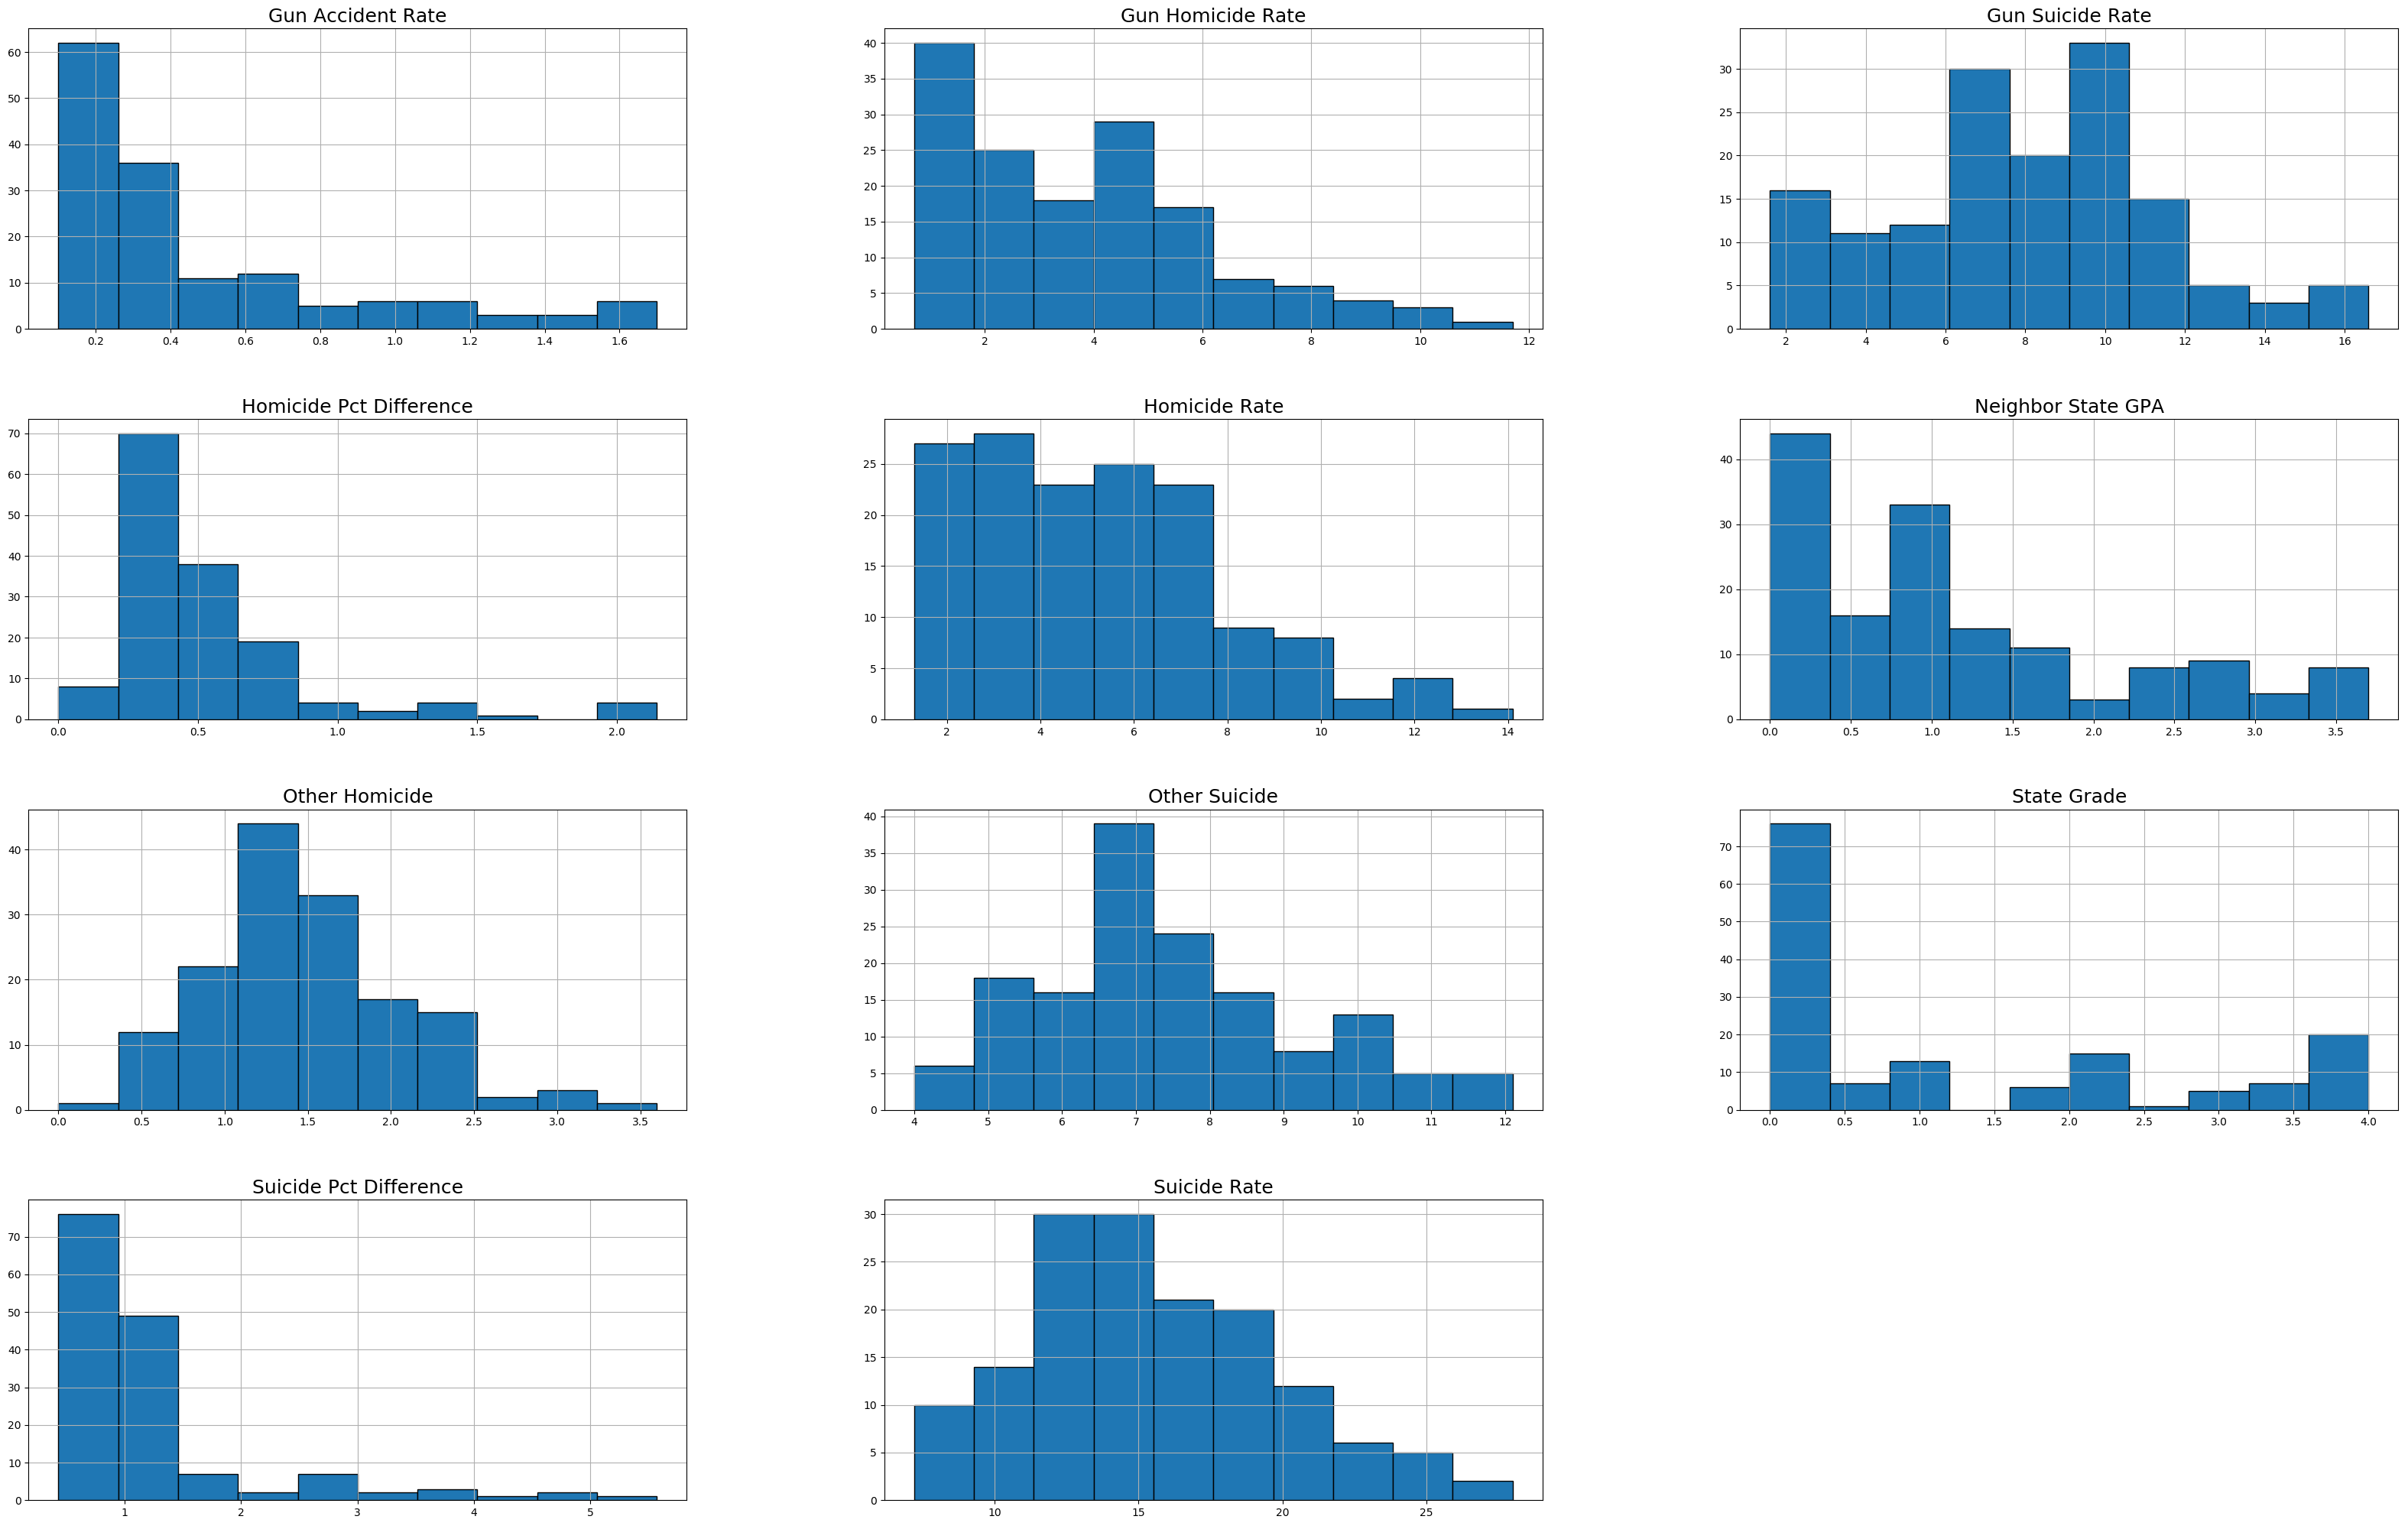

In [16]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# CDC data from 2014 & 2015 invalid
# Save compiled data for later, then filter df
compiled_data = df
df = df[df.columns[3:]]

# View feature distributions
fig = df.hist(figsize = (40, 25), ec='k')
[x.title.set_size(18) for x in fig.ravel()]
plt.show()

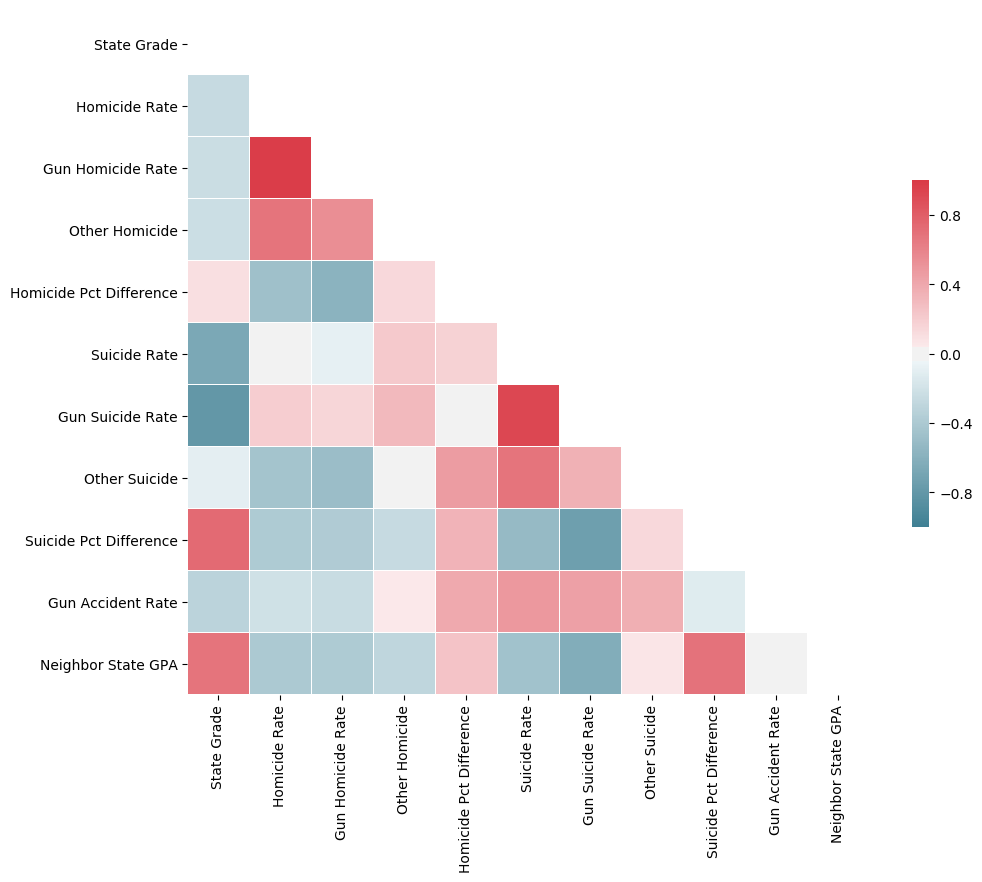

In [17]:
import seaborn as sns

def coll_check(data, size=(11,9)):
    mpl.rcParams.update(mpl.rcParamsDefault)
    
    # Create a covariance matrix
    corr = data.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize = size)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    

coll_check(df)

The most notable observation here is that, while the state gun law gpa does seem to have a strong correlatoin with gun death rates, the overall homicide rate appears to be completely unaffected. However, the grades of neighboring states seem to be what matter most in this regard, albeit very slightly. It remains to be seen if the relationship has any statistical significance.

If gun laws do affect gun deaths, it appears most likely to come from reductions in suicide rates.

### Regression Analysis
A simple, linear regression analysis to examine the impact that strength of gun laws have on Gun Death Rates and Homicide Rates.

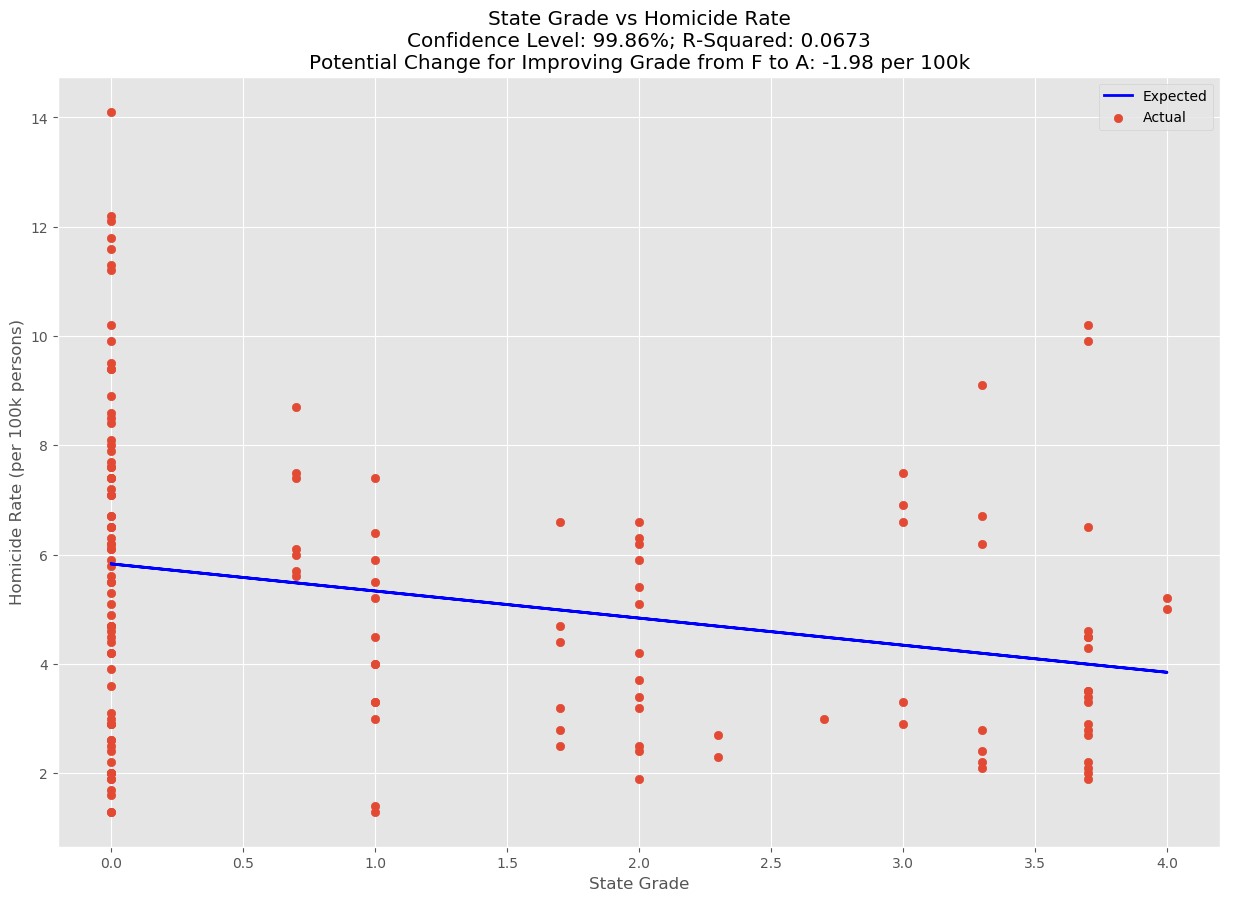

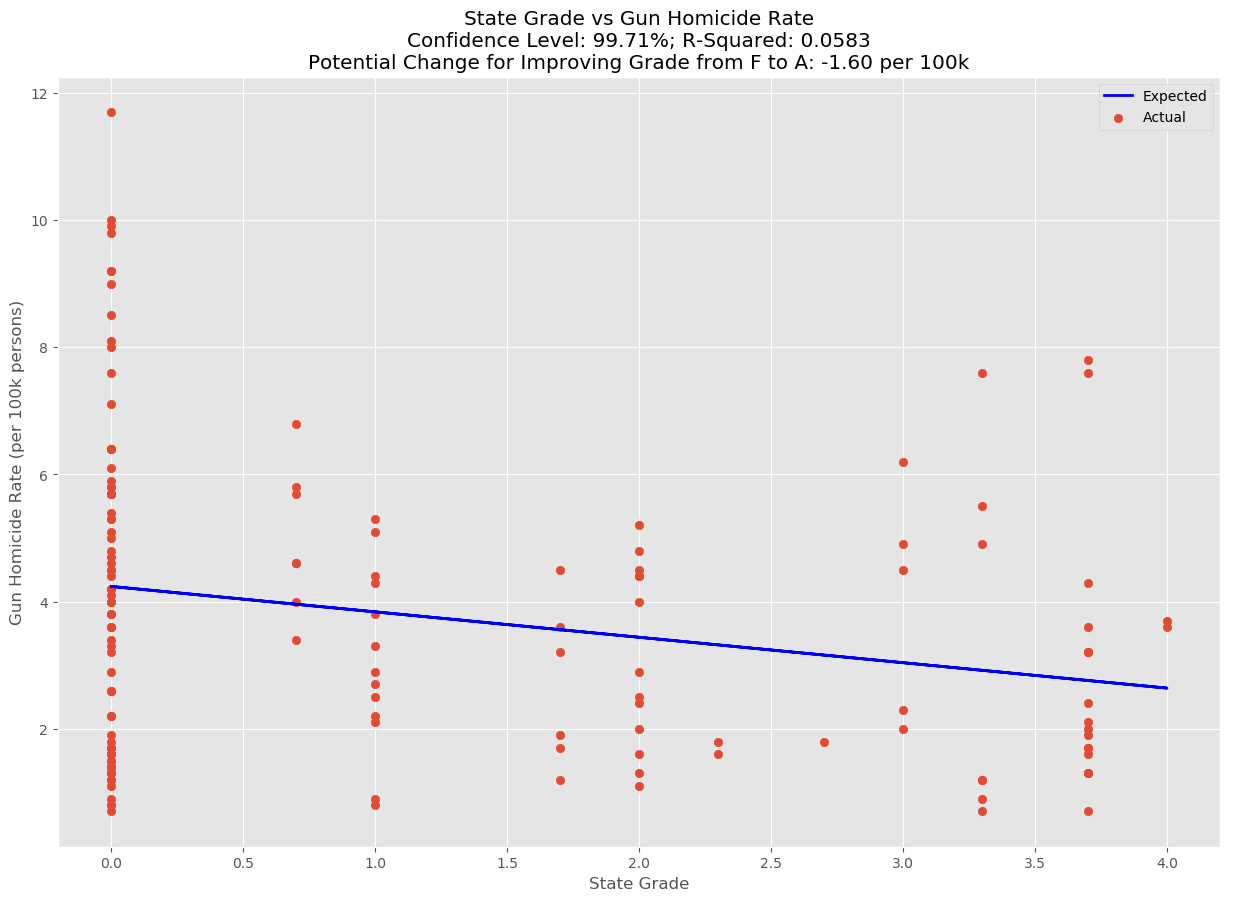

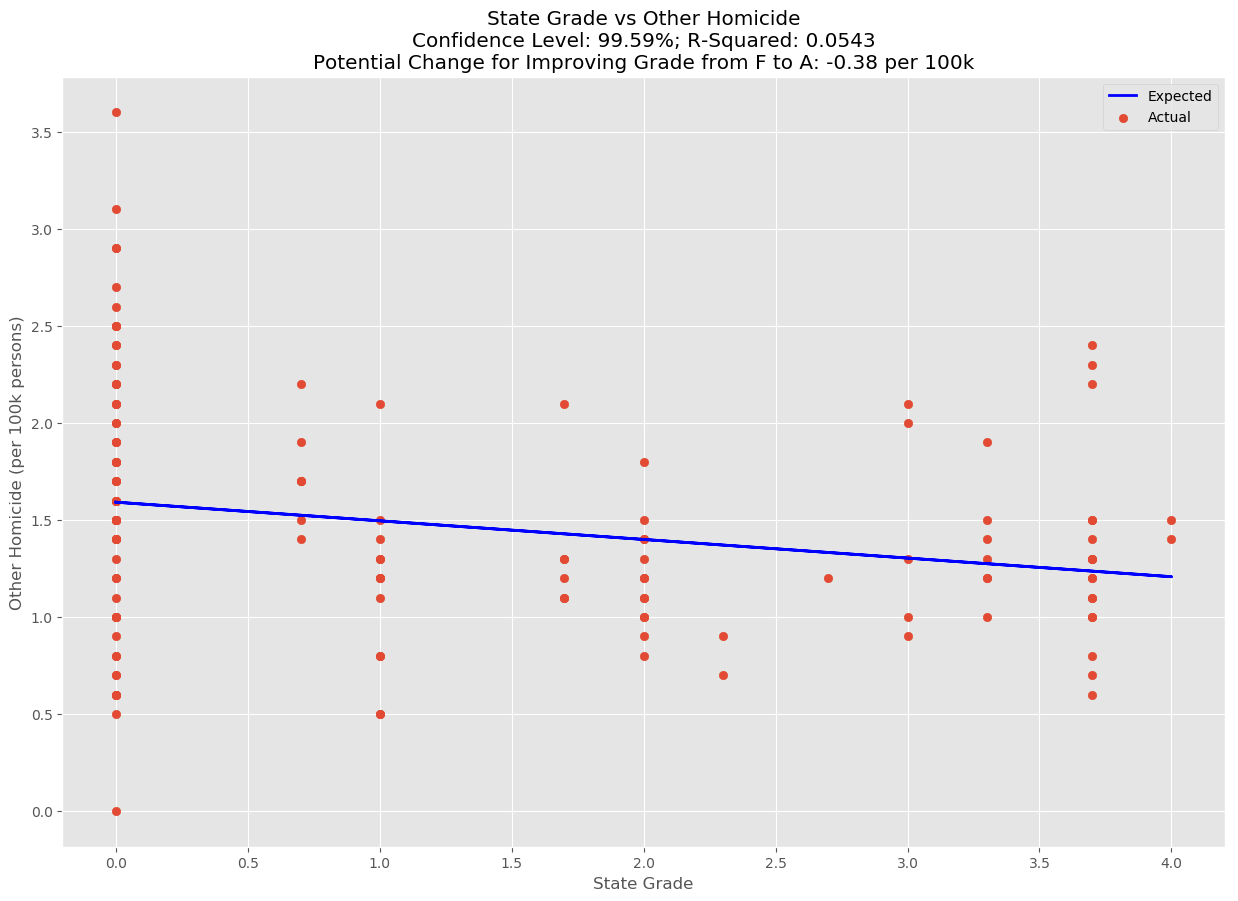

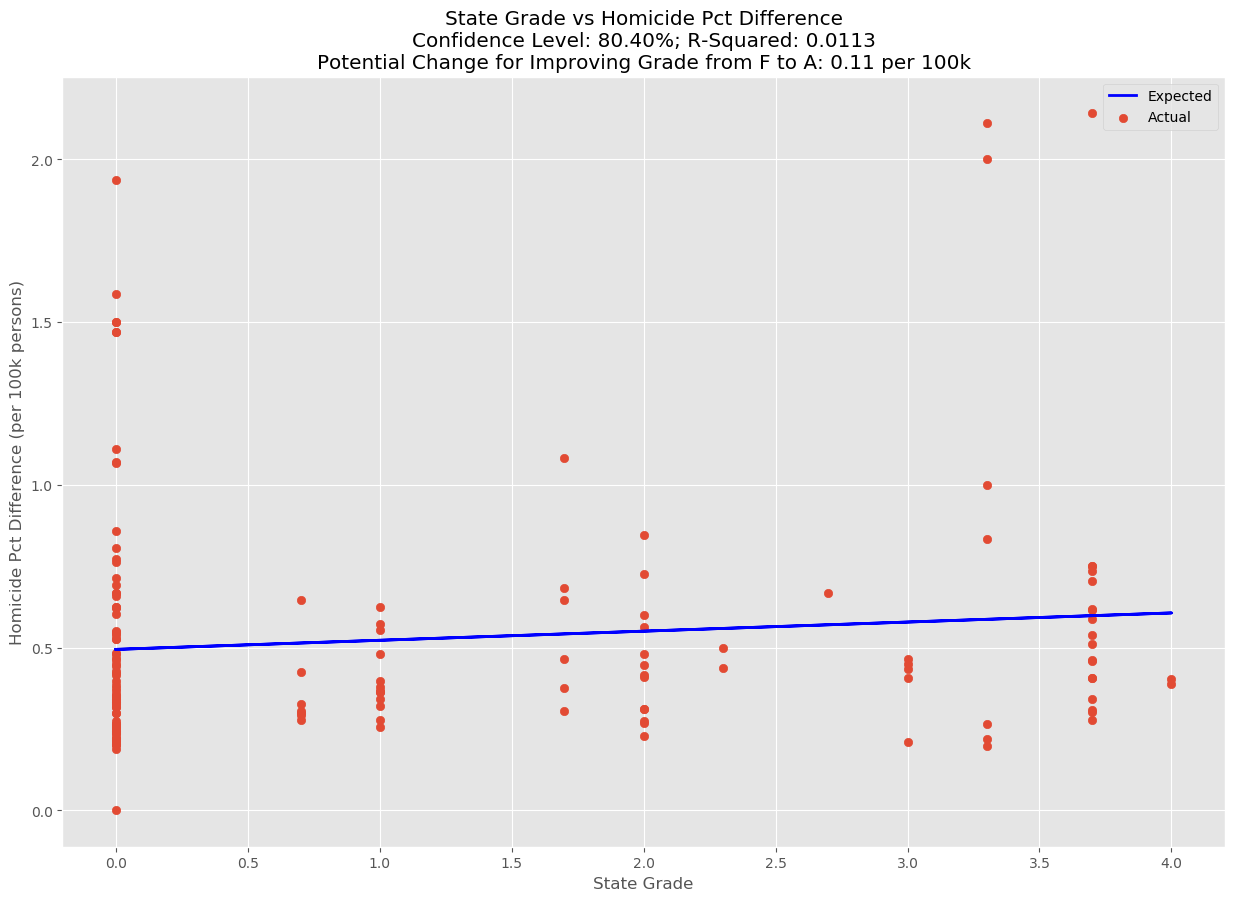

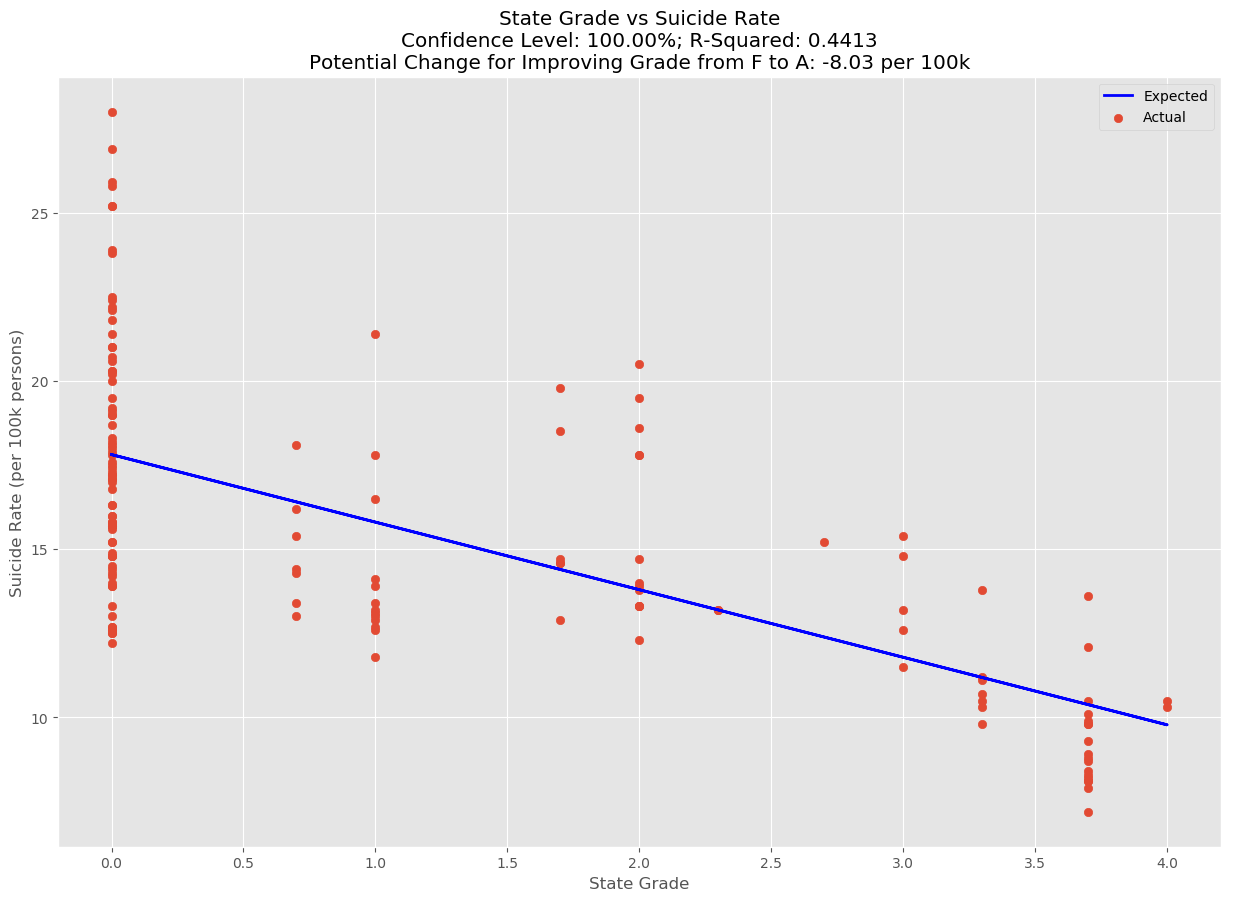

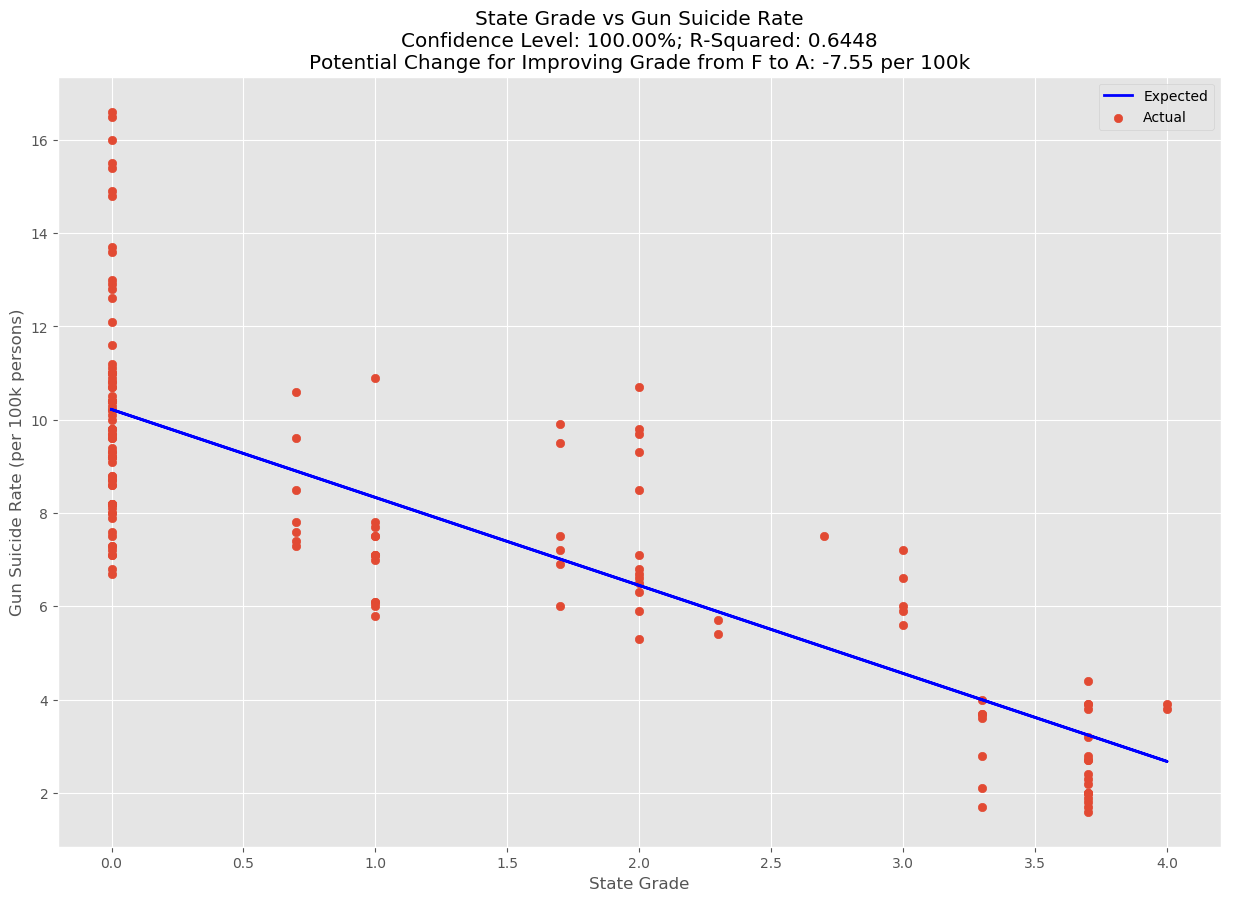

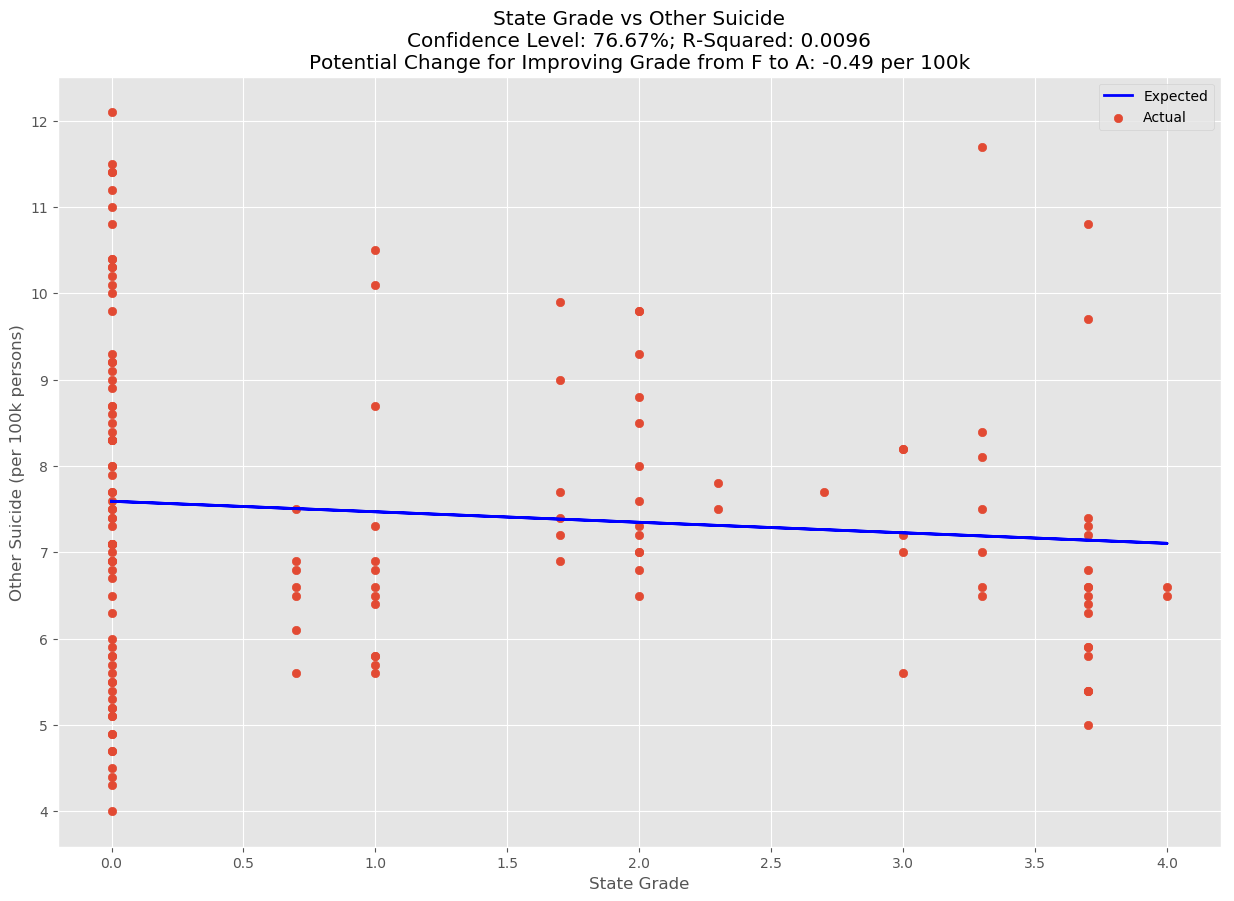

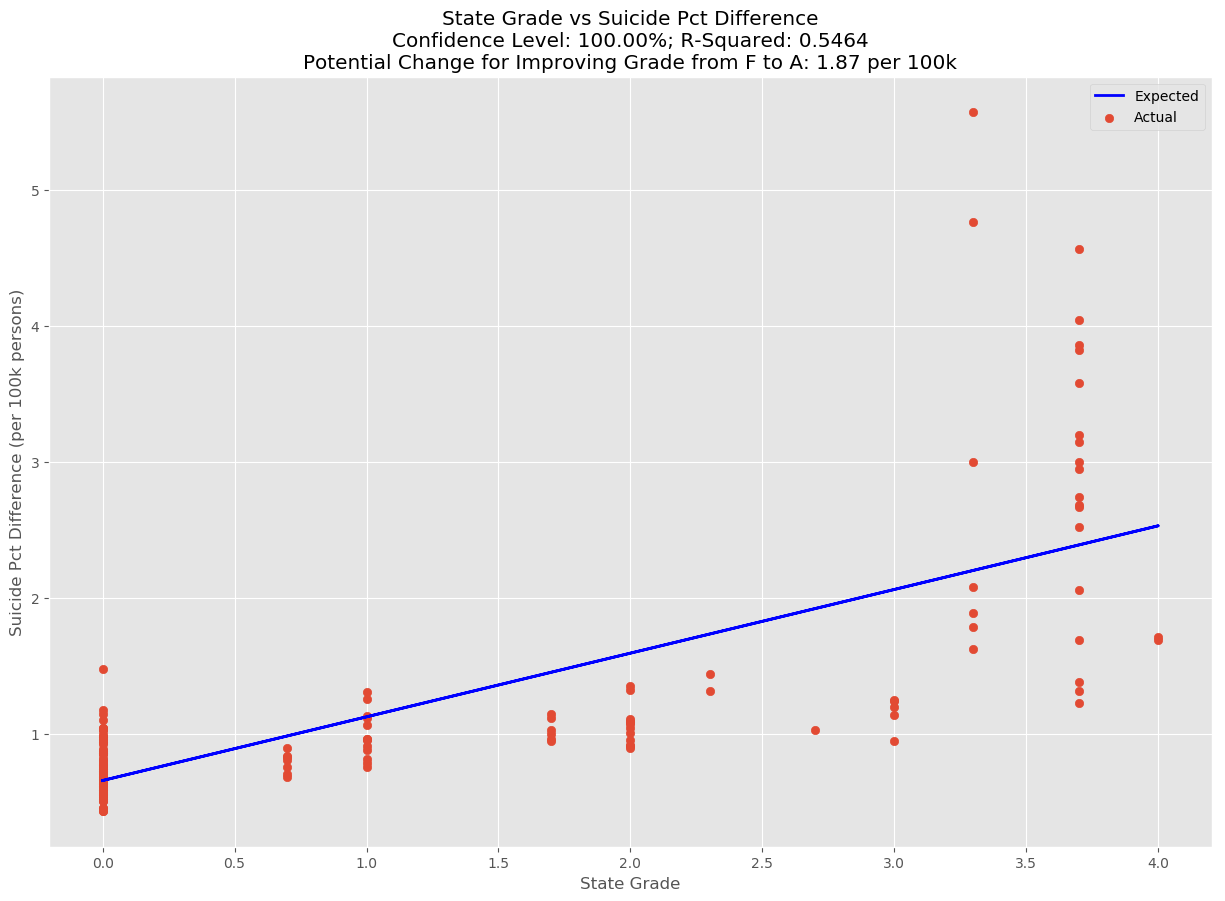

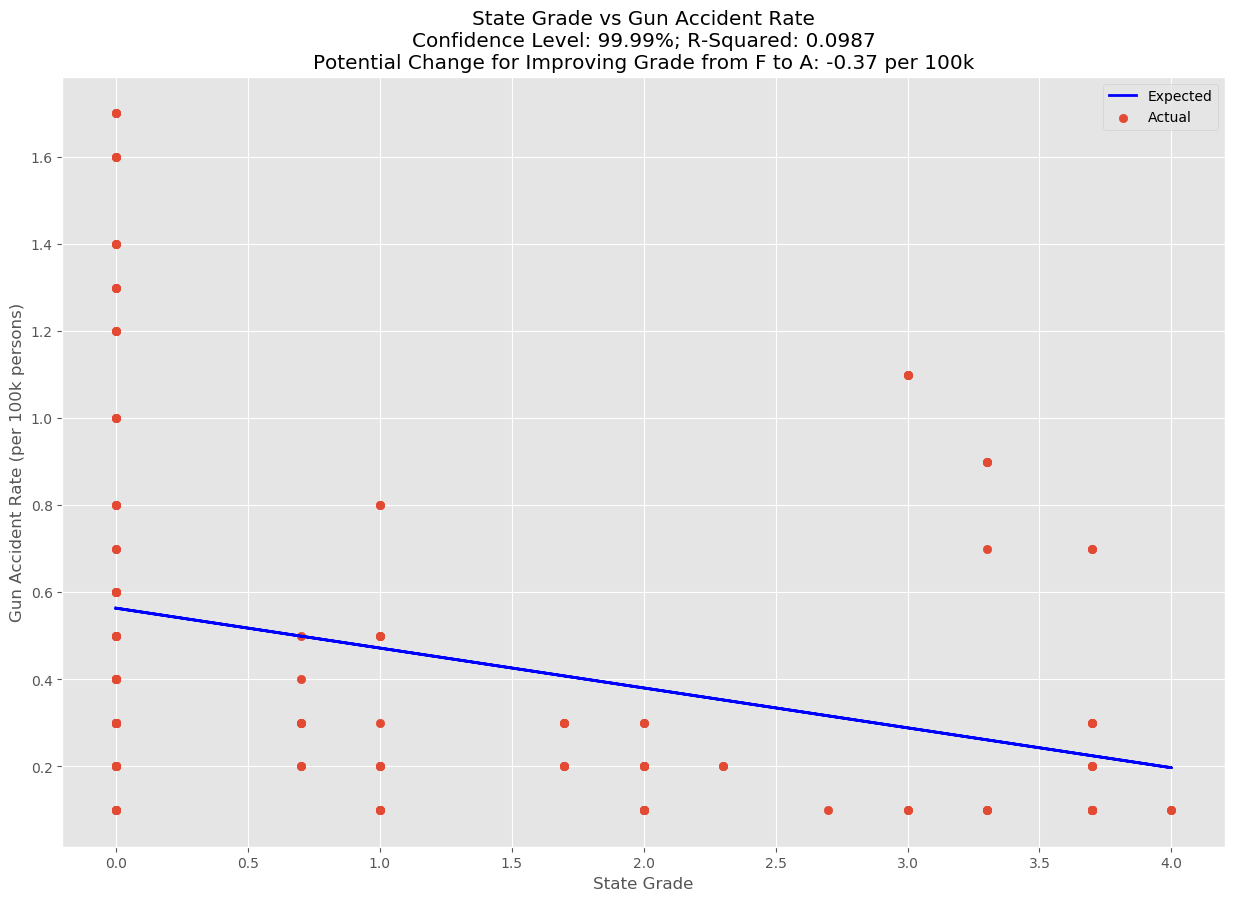

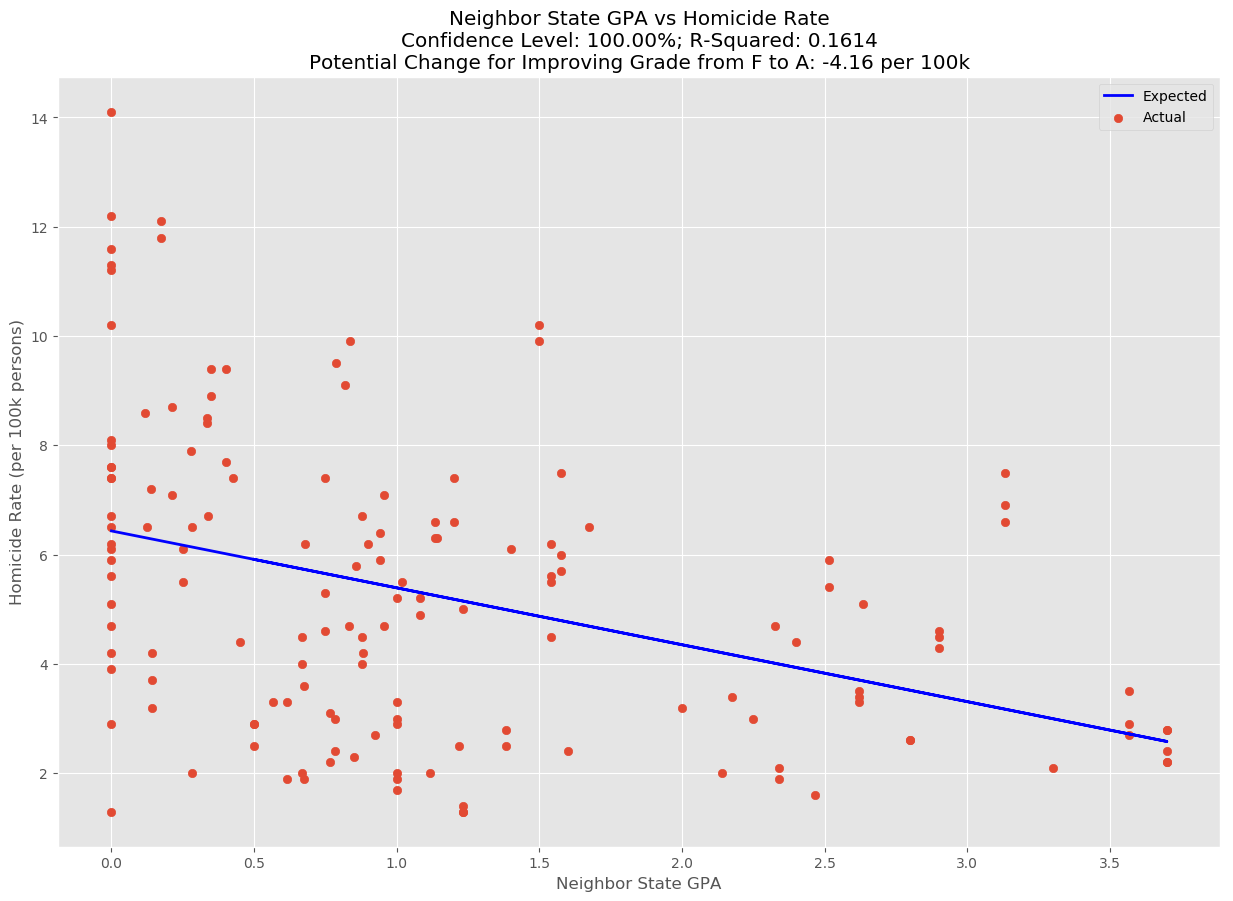

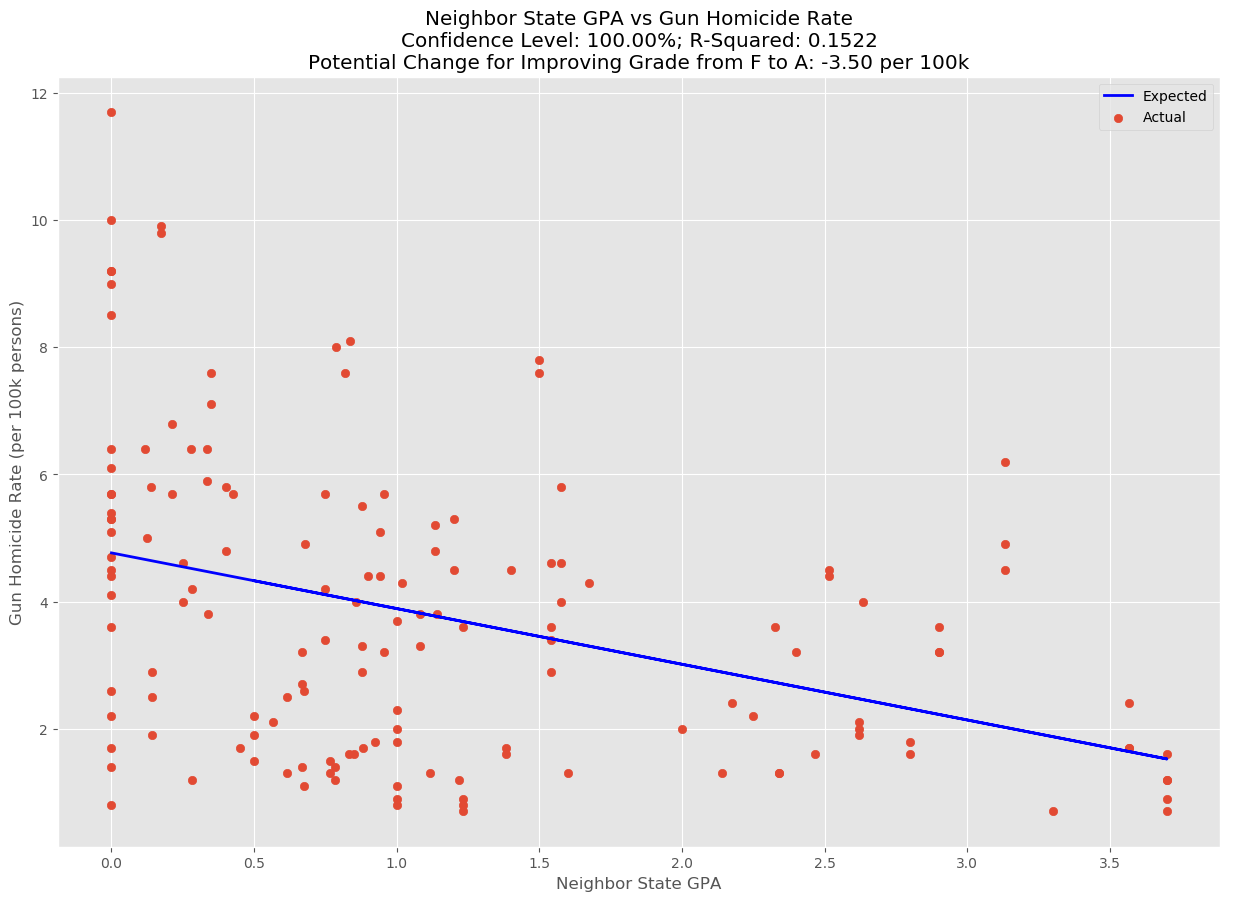

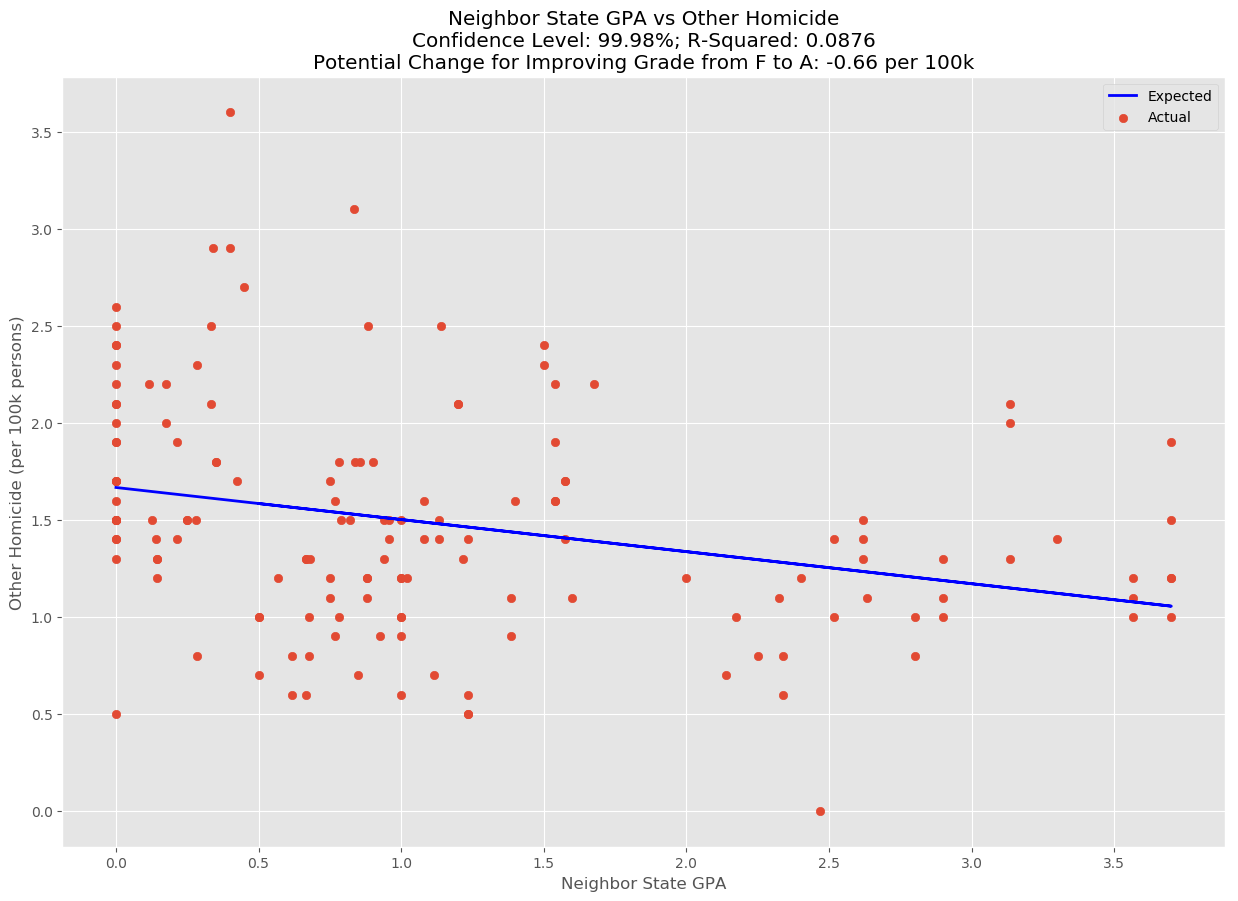

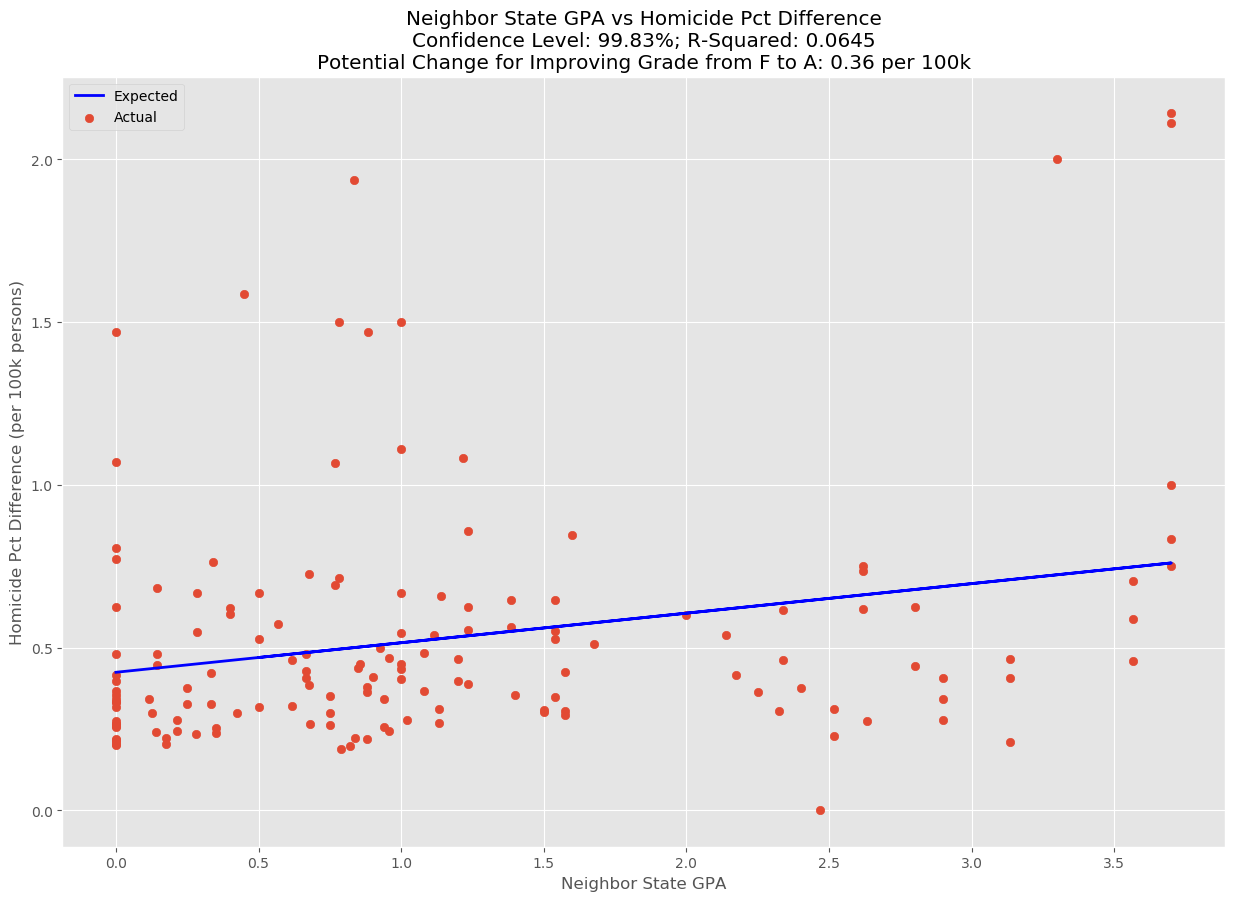

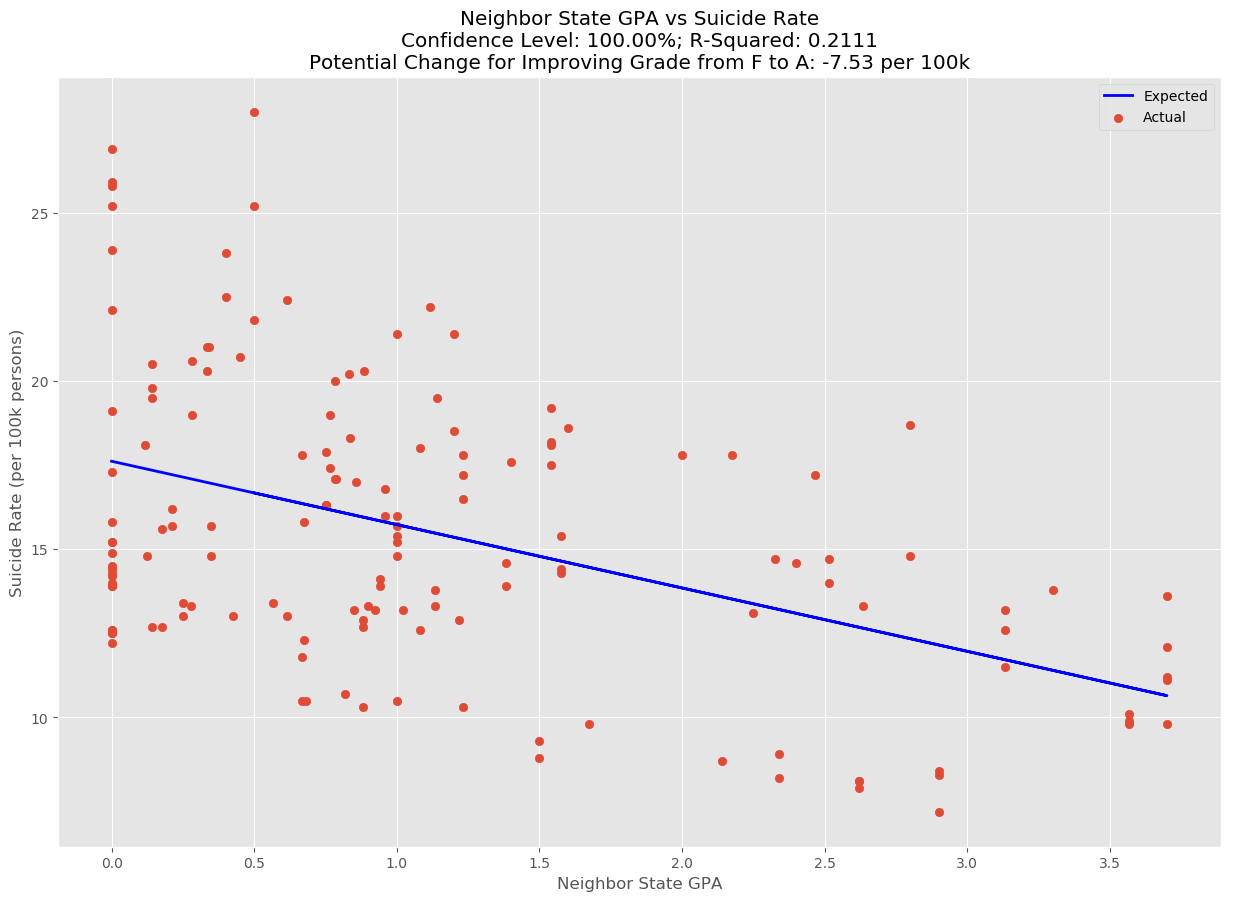

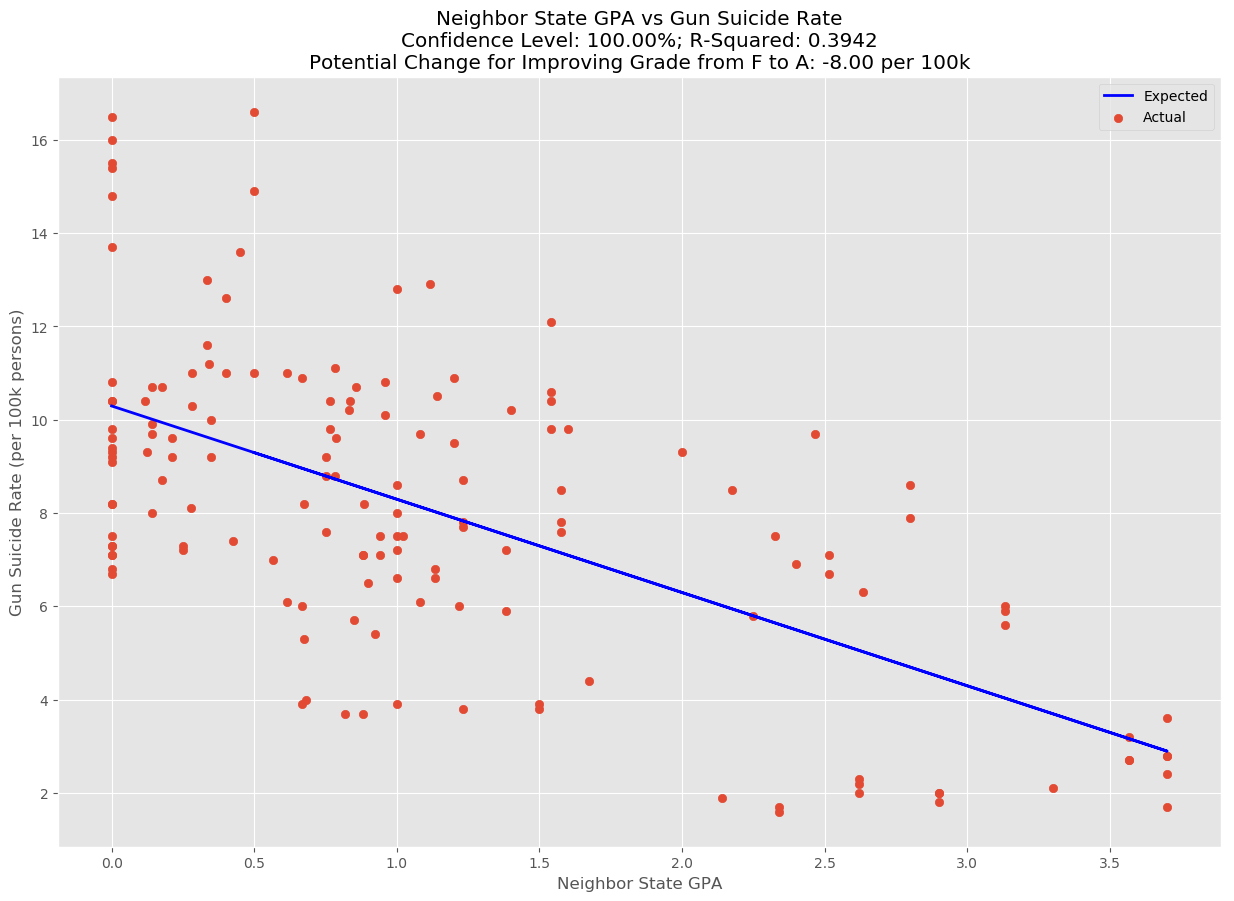

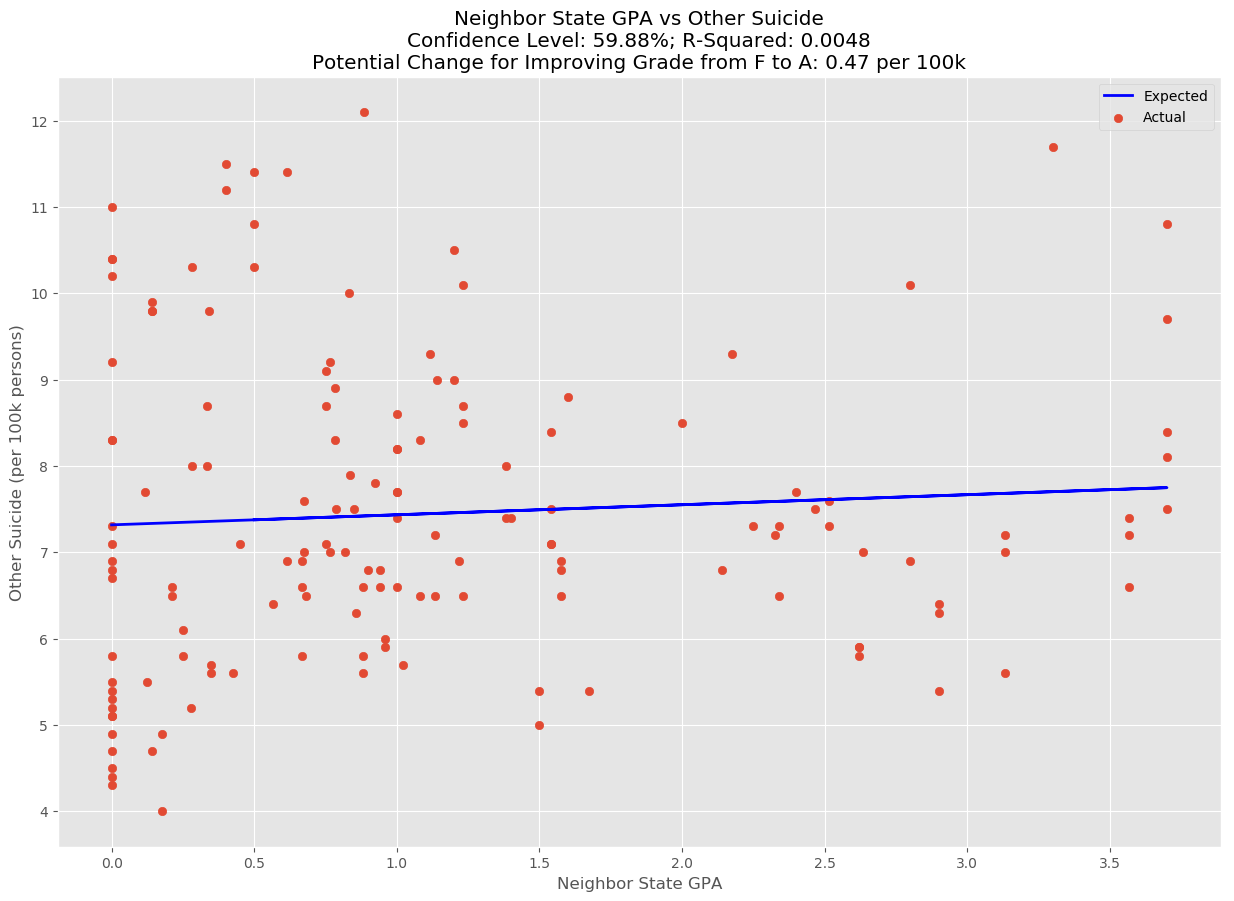

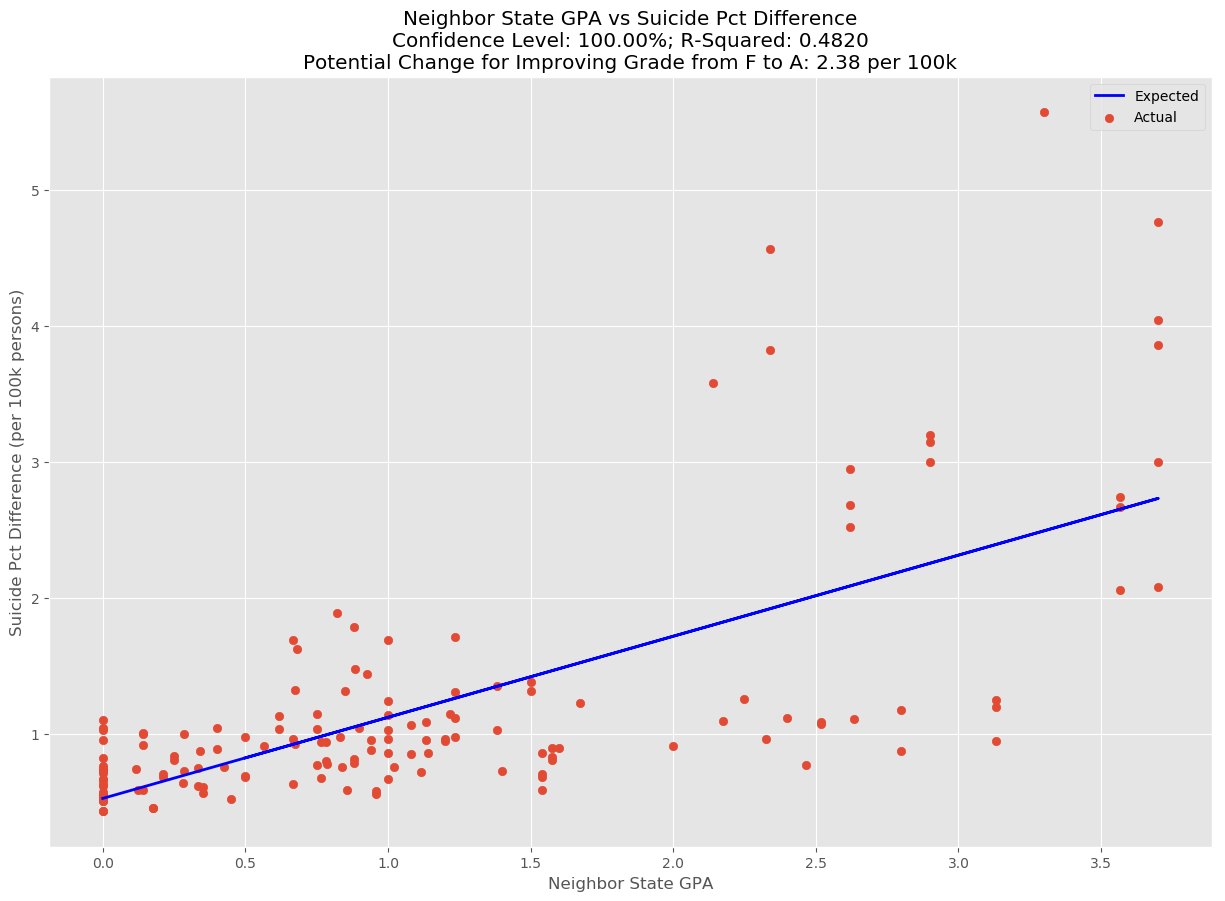

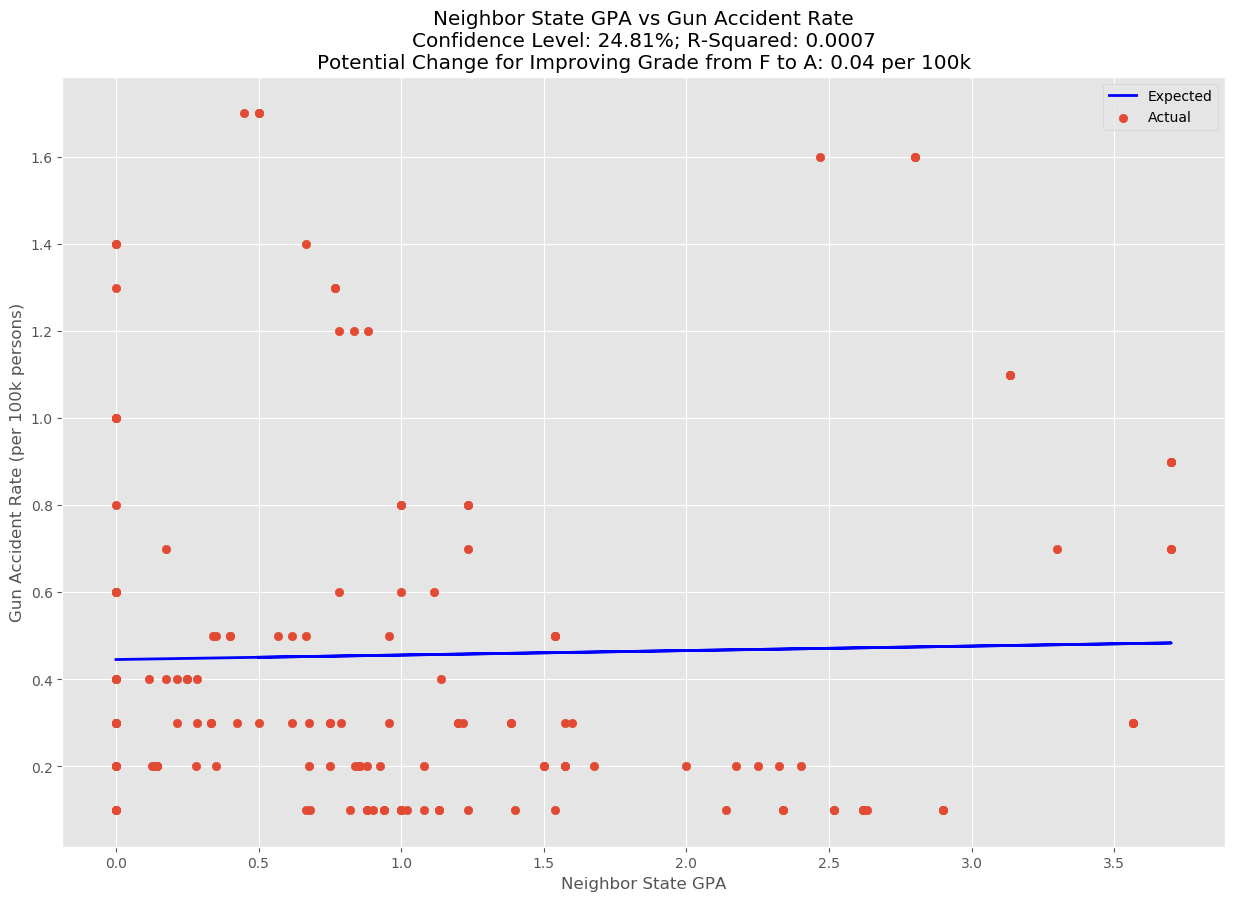

,Target,Predictor,R Squared,Intercept,Slope,P Value
0,Homicide_Rate,State_Grade,0.0673,5.8299,-0.4956,0.0014
1,Gun_Homicide_Rate,State_Grade,0.0583,4.2384,-0.3996,0.0029
2,Other_Homicide,State_Grade,0.0543,1.5915,-0.0960,0.0041
3,Homicide_Pct_Difference,State_Grade,0.0113,0.4949,0.0280,0.1960
4,Suicide_Rate,State_Grade,0.4413,17.8122,-2.0082,0.0000
5,Gun_Suicide_Rate,State_Grade,0.6448,10.2201,-1.8864,0.0000
6,Other_Suicide,State_Grade,0.0096,7.5920,-0.1218,0.2333
7,Suicide_Pct_Difference,State_Grade,0.5464,0.6584,0.4681,0.0000
8,Gun_Accident_Rate,State_Grade,0.0987,0.5637,-0.0916,0.0001
9,Homicide_Rate,Neighbor_State_GPA,0.1614,6.4335,-1.0410,0.0000


In [18]:
# Rename columns for regression model
for col in df.columns:
    df = df.rename(columns={col: col.replace(' ', '_')})

# Set target & predictor variables
targets = list(df.columns[1:-1])
predictors = ['State_Grade', 'Neighbor_State_GPA']

def regression(df, predictors, targets):
    results = [['Target', 'Predictor', 'R Squared', 'Intercept', 'Slope', 'P Value']]

    for predictor in predictors:
        Predictor = predictor.replace('_', ' ')

        for target in targets:
            Target = target.replace('_', ' ')

            if predictor != target:
                # Fit & predict model
                f = f'{target}~{predictor}'
                model = smf.ols(formula=f, data=df).fit()
                y_pred = model.predict()

                # Append list of summary statistics to results
                results.append([target, 
                                predictor, 
                                np.round(model.rsquared, 4), 
                                np.round(model.params[0], 4), 
                                np.round(model.params[1], 4), 
                                np.round(model.pvalues[1], 4)])

                # Plot results
                plt.figure(figsize=(15, 10))
                plt.style.use('ggplot')
                plt.title(f'{Predictor} vs {Target}\n'
                          f'Confidence Level: {100*(1 - model.pvalues[1]):.2f}%; R-Squared: {model.rsquared:.4f}\n'
                          f'Potential Change for Improving Grade from F to A: {model.params[1]*4:.2f} per 100k')
                plt.xlabel(Predictor)
                plt.ylabel(f'{Target} (per 100k persons)')
                plt.scatter(df[predictor], df[target], marker='o', label='Actual')
                plt.plot(df[predictor], y_pred, color='b', lw=2, label='Expected')
                plt.legend()
                plt.show()

        # Create dataframe from results
        result_df = pd.DataFrame(results[1:],columns=results[0])

    return result_df
    
regression(df, predictors, targets)

## Observations
These results make it quite clear that strict gun laws (based on Giffords Law rating) do have a significant impact on overall gun deaths, particularly with regard to suicide deaths. Homicide and accidental deaths remain relatively unaffected. Indeed, the decrease in suicide deaths actually seem to exceed the total firearm deaths, though this slight disparity is likely due to random fluctuations from year to year. 

To ensure the data is properly fitted, a test/train split will be conducted and model tested on unseen data. State grades and neighbor state gpa's will be included in a multi-linear regression.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import warnings

warnings.filterwarnings('ignore')

def train_linreg(X, y, predictor, target, rand_state=123):    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.25, 
                                                        random_state=rand_state)

    predictions_df = X_test[['State-Year']]
    X_train = X_train[[predictor]]
    X_test = X_test[[predictor]]
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)

    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)

    score = r2_score(y_test, y_hat_test)
    
    predictions_df['Predicted'] = np.round(y_hat_test, 1)
    predictions_df['Actual'] = y_test
    predictions_df = predictions_df.set_index('State-Year')
    
    return predictions_df, score

def results_distribution(X, y, predictor, target, n=100):
    scores = []
    Predictor = predictor.replace('_', ' ')
    Target = target.replace('_', ' ')
    
    print(f'\nCalculating Average Score for {Predictor} vs {Target}')
    for i in range(n):
        pred_df, score = train_linreg(X, y, predictor, target, rand_state=i)
        scores.append(score)

        if (100 * ((i+1) / n)) % 25 == 0:
            print(f'{int(100 * (i+1)/n)}% Complete')

    plt.figure(figsize=(20, 5))
    sns.distplot(scores)
    plt.title(f'{Predictor} vs {Target} R-Square Scores Distribution\nAverage R-Squared: {np.mean(scores)*100:.2f}%')
    plt.xlabel('R-Square Value')
    plt.ylabel('Frequency')
    plt.show()


Calculating Average Score for State Grade vs Suicide Rate
25% Complete
50% Complete
75% Complete
100% Complete


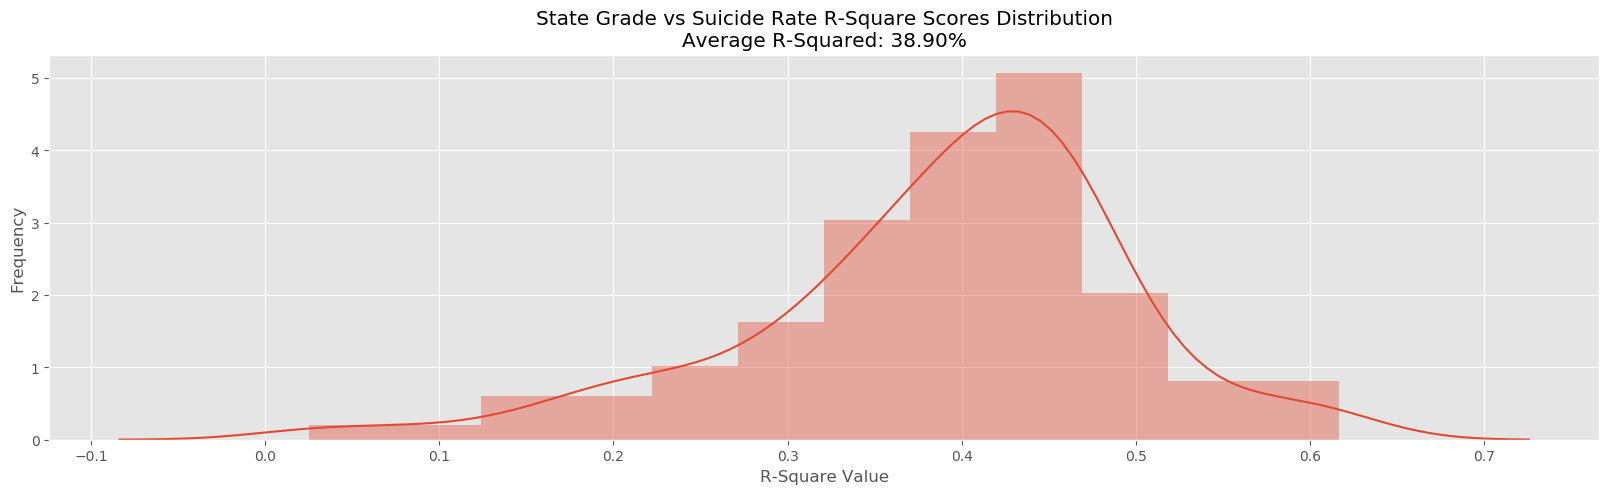


Calculating Average Score for State Grade vs Homicide Rate
25% Complete
50% Complete
75% Complete
100% Complete


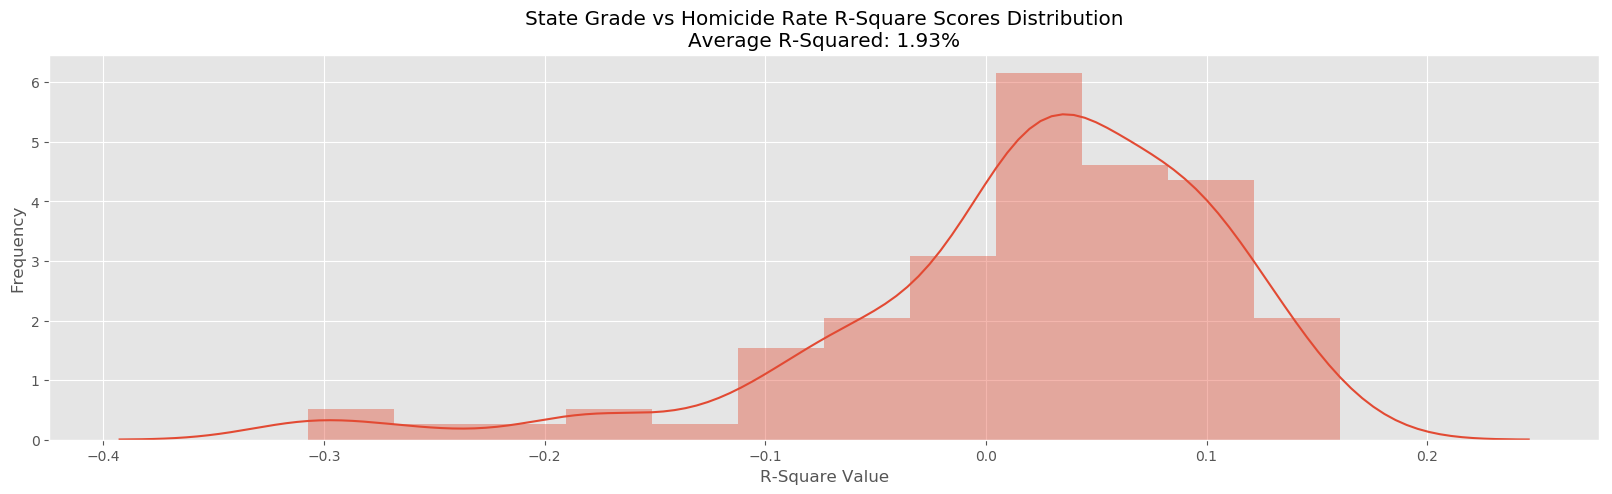


Calculating Average Score for Neighbor State GPA vs Suicide Rate
25% Complete
50% Complete
75% Complete
100% Complete


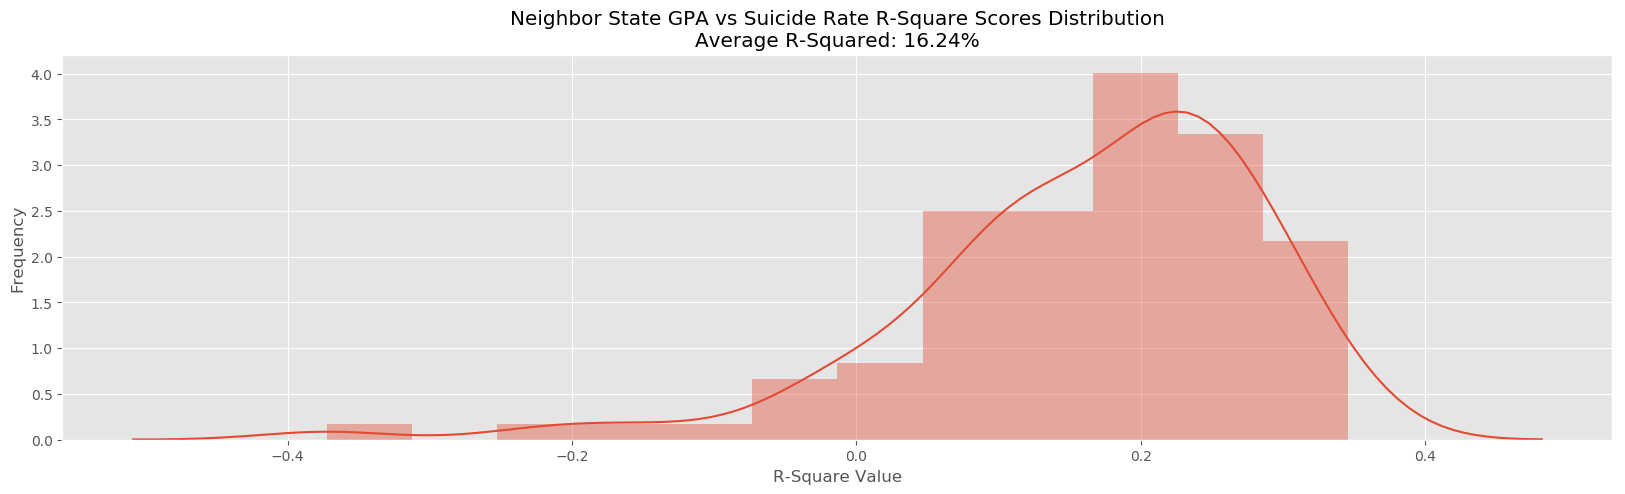


Calculating Average Score for Neighbor State GPA vs Homicide Rate
25% Complete
50% Complete
75% Complete
100% Complete


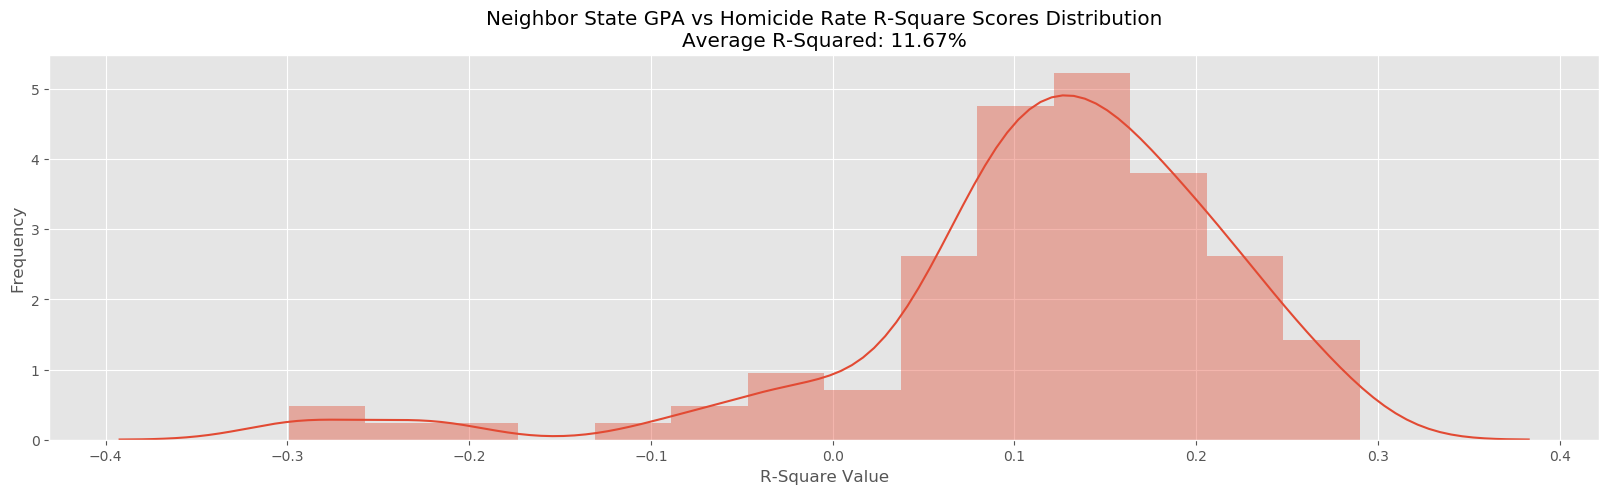

In [20]:
predictors = ['State_Grade', 'Neighbor_State_GPA']
targets = ['Suicide_Rate', 'Homicide_Rate']

for predictor in predictors:
    for target in targets:
        X = df.reset_index()[['State-Year', predictor]]
        y = df.reset_index()[target]
        results_distribution(X, y, predictor, target, 100)

Test performance was better than training performance when looking at state grade as the sole predictor.

## Multilinear Regression
It seems surrounding state grades may have an impact as well, but we should check this in tandem with state laws to see which, if either, has a stronger impact.

In [21]:
for target in ['Homicide_Rate', 'Suicide_Rate']:
    f = f'{target}~+State_Grade+Neighbor_State_GPA'
    model = smf.ols(formula=f, data=df).fit()
    print(model.summary())
    print('\n\n\n')

                            OLS Regression Results                            
Dep. Variable:          Homicide_Rate   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     14.20
Date:                Sat, 31 Aug 2019   Prob (F-statistic):           2.29e-06
Time:                        10:49:27   Log-Likelihood:                -349.01
No. Observations:                 150   AIC:                             704.0
Df Residuals:                     147   BIC:                             713.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              6.4272      0

## Conclusions
### Suicide
The results are clear that stronger gun laws have a substantial and significant impact on suicide rates. In addition to p-value and r-squared values, the test performance was improved over training results using RMSE as the key metric. The OLS summary revealed, however, that neighboring states have less impact than seems at first glance. These rates are directly tied to gun laws within the state. 

Given that the national suicide rate in 2017 was 14 per 100,000, half of all suicides result from gun deaths, and states that have an A rating have an average 5 fewer suicides as a direct result of those laws, it can be estimated that if F-rated states improve their laws to meet the A-rating, suicide deaths might be reduced by an average 35% in those states.

### Homicide / Accidental Deaths
The reduction in suicide deaths account for practically all of the reductions in firearm deaths, with almost no impact on homicide or accidental deaths. What is unknown is whether criminals use alternate means of committing homicides, or if they simply don't disarm. Without a distinction made between firearm and non-firearm homicides at the state level, this will not be possible to determine. However, by looking at data on an international level, comparing results across nations, we may be able to get more incite.

# Getting More Data
## Mass Murders
Dataset downloaded from the University of Maryland's [Global Terrorism Database](https://www.start.umd.edu/gtd). Mass shootings are defined as those where the total number of fatalities is 6 or more. Filters were applied to gather data only in the United States where firearms was a weapon of choice. All weapons types were considered, with the exception of CBD. In addition, failed attemps will also be considered, so instances where injuries are 10+ or fatalities exceed 5 will be included.

In [22]:
# url = str('https://www.start.umd.edu/gtd/search/ResultsCSV.aspx?csv=1&'
#           'casualties_type=b&casualties_max=&start_yearonly=1991&end_year'
#           'only=2017&dtp2=all&success=no&country=217&weapon=6,7,5,8,9,11,13,10')

# mass_shooting_data = pd.read_csv(url, usecols=np.arange(20))
# mass_shooting_data.to_csv('national_data/mass_shootings.csv')

mass_shooting_data = pd.read_csv('global_terrorism_database/mass_shootings.csv')

cols = [2, 4, 12, 11, -1]
mass_shooting_data = mass_shooting_data[mass_shooting_data.columns[cols]]
mass_shooting_data.head()

,DATE,CITY,INJURED,FATALITIES,WEAPON TYPE 1
0,2017-12-22,Harrisburg,1,1,Firearms
1,2017-12-22,Harrisburg,0,0,Firearms
2,2017-12-11,New York City,4,0,Explosives/Bombs/Dynamite
3,2017-12-07,Aztec,0,3,Firearms
4,2017-11-13,Vale,0,0,Incendiary


In [23]:
for col in ['FATALITIES', 'INJURED']:
    clean_col = []
    for item in mass_shooting_data[col]:
        try:
            clean_col.append(int(item))
        except:
            clean_col.append(0)
    mass_shooting_data[col] = clean_col
    mass_shooting_data = mass_shooting_data.rename(columns={col:col.title()})

mass_shooting_data = mass_shooting_data[(mass_shooting_data['Fatalities']>=6) | (mass_shooting_data['Injured'] >= 10)]

mass_shooting_data['Year'] = [int(date[:4]) for date in mass_shooting_data['DATE']]
mass_shooting_data = mass_shooting_data.reset_index(drop=True)

mass_shooting_data

,DATE,CITY,Injured,Fatalities,WEAPON TYPE 1,Year
0,2017-10-31,New York City,13,8,Vehicle (not to include vehicle-borne explosives,2017
1,2017-10-01,Las Vegas,851,59,Firearms,2017
2,2017-08-12,Charlottesville,19,1,Vehicle (not to include vehicle-borne explosives,2017
3,2016-11-28,Columbus,11,1,Melee,2016
4,2016-09-17,St. Cloud,10,1,Melee,2016
5,2016-09-17,New York City,29,0,Explosives/Bombs/Dynamite,2016
6,2016-07-07,Dallas,9,6,Firearms,2016
7,2016-06-12,Orlando,53,50,Firearms,2016
8,2015-12-02,San Bernardino,17,16,Explosives/Bombs/Dynamite,2015
9,2015-10-01,Roseburg,7,10,Firearms,2015


### Manual Inspection of Data
Incidents that use weapons that would not be seen as an effective substitute for unavailability of guns will be dropped. For example, use of planes on 9/11 could hardly be seen as an alternative weapon of choice because of gun restrictions. A list of index numbers will be used to clearly identify which items will be dropped.

In [24]:
to_drop = [5, 15, 16, 20, 21, 22, 23, 28]
mass_shooting_data = mass_shooting_data.drop(to_drop)

# Change San Bernardino to firearm
mass_shooting_data.loc[8,'WEAPON TYPE 1'] = 'Firearms'

# Shootout 4 days after Boston bombing
mass_shooting_data.loc[13,'WEAPON TYPE 1'] = 'Firearms'

mass_shooting_data['State'] = ['New York', 
                               'Nevada', 
                               'Virginia', 
                               'Ohio', 
                               'Minnesota', 
                               'Texas', 
                               'Florida', 
                               'California', 
                               'Oregon', 
                               'Tennessee', 
                               'South Carolina', 
                               'California', 
                               'Massachusetts',
                               'Texas', 
                               'Wisconsin', 
                               'Texas', 
                               'Texas', 
                               'Colorado', 
                               'Georgia', 
                               'New York', 
                               'Arizona']

mass_shooting_data['State-Year'] = mass_shooting_data.State + ' ' + mass_shooting_data.Year.astype('str')
mass_shooting_data = mass_shooting_data.rename(columns={'WEAPON TYPE 1': 'Attack Type', 'CITY': 'City'})
mass_shooting_data = mass_shooting_data[['State-Year', 'City', 'Injured', 'Fatalities', 'Attack Type']].set_index('State-Year')
mass_shooting_data['Attack Type'] = ['Mass Shooting' if weapon=='Firearms' else 'Other Attack' for weapon in mass_shooting_data['Attack Type']]
mass_shooting_data

,City,Injured,Fatalities,Attack Type
State-Year,,,,
New York 2017,New York City,13,8,Other Attack
Nevada 2017,Las Vegas,851,59,Mass Shooting
Virginia 2017,Charlottesville,19,1,Other Attack
Ohio 2016,Columbus,11,1,Other Attack
Minnesota 2016,St. Cloud,10,1,Other Attack
Texas 2016,Dallas,9,6,Mass Shooting
Florida 2016,Orlando,53,50,Mass Shooting
California 2015,San Bernardino,17,16,Mass Shooting
Oregon 2015,Roseburg,7,10,Mass Shooting


## Append Mass Homicide Data
Even though filters included situations where there were at least 10 injuries, fatality data is the only item of interest. Though other types of attacks may be attempted, differences in survivability are of interest as well.

In [25]:
# Join attack types & fatalities
mass_kill_df = gun_mortality_df.join(mass_shooting_data[['Fatalities']]).fillna(0)
mass_kill_df = mass_kill_df.join(mass_shooting_data['Attack Type']).fillna('None')

# Get dummies for shooting vs other attacks
mass_kill_df = mass_kill_df.join(pd.get_dummies(mass_kill_df['Attack Type'])).drop(['None', 'Attack Type'], axis=1)
mass_kill_df[mass_kill_df.Fatalities>0]

,State,Year,Homicide Rate,Gun Homicide Rate,Other Homicide,Homicide Pct Difference,Suicide Rate,Gun Suicide Rate,Other Suicide,Suicide Pct Difference,Fatalities,Mass Shooting,Other Attack
State-Year,,,,,,,,,,,,,
Arizona 1995,Arizona,1995,11.4,8.4,3.0,0.357143,18.2,12.4,5.8,0.467742,1.0,0,1
Georgia 1996,Georgia,1996,9.3,6.6,2.7,0.409091,11.8,8.8,3.0,0.340909,1.0,0,1
New York 1995,New York,1995,8.3,5.6,2.7,0.482143,7.4,2.8,4.6,1.642857,8.0,1,0
California 2014,California,2014,4.5,3.2,1.3,0.406250,10.5,3.9,6.6,1.692308,4.0,1,0
California 2015,California,2015,5.0,3.6,1.4,0.388889,10.3,3.8,6.5,1.710526,16.0,1,0
Colorado 1999,Colorado,1999,4.5,2.7,1.8,0.666667,13.7,7.5,6.2,0.826667,15.0,1,0
Florida 2016,Florida,2016,6.7,5.3,1.4,0.264151,13.9,7.1,6.8,0.957746,50.0,1,0
Massachusetts 2013,Massachusetts,2013,2.1,1.3,0.8,0.615385,8.1,1.6,6.5,4.062500,2.0,1,0
Minnesota 2016,Minnesota,2016,2.3,1.6,0.7,0.437500,13.2,5.7,7.5,1.315789,1.0,0,1


In [26]:
for attack in ['Mass Shooting', 'Other Attack']:
    atck_df = mass_kill_df[mass_kill_df[attack]==1]['Fatalities']
    avg, ct = atck_df.mean(), atck_df.count()
    print(f'Total {attack}s:\t{ct}\nMortality Rate:\t\t{avg:.2f}\n')    

Total Mass Shootings:	12
Mortality Rate:		12.17

Total Other Attacks:	6
Mortality Rate:		3.50



Given the disparity in mortality rates, little weight should be given to suggestions that mass murdurers will use other weapons if guns are not available. Even if the suggestions prove to be true, reductions in life lost can still be significantly realized. If the same rates were maintained and all mass shootings were other forms of attack, 104 lives would have been spared.

## Gun Law Features Over Time
[Everytown Research](https://everytownresearch.org)

In [27]:
# def inspect_csv(topic, q_num):
    
#     #read & format csv
#     q = pd.read_csv(f'everytown_questions/{topic}/q{q_num}.csv')
#     q = q[q.columns[:5]][(q.state != 'DC') & (q.year <= 2017) & (q.year >= 1991)]
#     q['State'] = [state_abbrs[st] for st in q['state']]
#     q['State-Year'] = q.State + ' ' + q.year.astype('str')
    
#     #inspect length of longest response
#     max_len = 0
#     for resp in q.response:
#         new_resp = str(resp)
#         n = len(new_resp.split(' '))
#         max_len = n if n > max_len else max_len
    
#     #identify type of response: boolean, qualitative, or categorical
#     if max_len == 1:
#         q_type = 'Boolean'
#     elif max_len > 4:
#         q_type = 'Free Form'
#     else:
#         q_type = 'Categorical'
        
#     num_apps = len(q['applies to'].unique())
    
        
#     return q, q_type, num_apps

In [28]:
# def type_bool(q, topic, q_num, num_apps, init_q):

#     cl_q = init_q[(init_q.State != 'District of Columbia') & (init_q.Year <= 2017)] 
#     q = q.dropna()
#     for col in ['response', 'applies to']:
#         q[col] = q[col].astype('str')
#         q[col] = [val.lower().strip() for val in q[col]]
    
#     # Define 0 responses
#     neg_resps = ['no', '0']
    
#     # Create question response columns based on number of 'applies to' response types
#     if num_apps == 1:
#         col = f'{topic}_q{q_num}'
#         cl_q[col] = [0 for i in range(1350)]
        
#     else:
#         dummy_cols = pd.get_dummies(q['applies to']).drop('all', axis=1).columns
#         for dumb_col in dummy_cols:
#             new_col = f'{topic}_q{q_num}_{dumb_col.replace(" ", "_")}'
#             cl_q[new_col] = [0 for i in range(1350)]
        
#     for i in range(len(q.index)):
#         # Get response results
#         resp = str(q.iloc[i]['response'])
#         if resp not in neg_resps:
#             app = str(q.iloc[i]['applies to'])
#             st = q.iloc[i]['State']
#             yr = q.iloc[i]['year']
#             ix = f'{st} {yr}'

#             if num_apps == 1:
#                 cl_q.loc[ix, col] = 1

#             elif app != 'all':
#                 resp_col = f'{topic}_q{q_num}_{app.replace(" ", "_")}'
#                 cl_q.loc[ix, resp_col] = 1

#             else:
#                 for col in dummy_cols:
#                     resp_col = f'{topic}_q{q_num}_{col.replace(" ", "_")}'
#                     cl_q.loc[ix, resp_col] = 1
                            
#     return cl_q

In [29]:
# import os
# import warnings

# warnings.filterwarnings('ignore')

# question_index = {}

# # questions_df = mass_kill_df

# init_dict = {'State': [], 'Year': []}
# for year in range(1991, 2018):
#     for state in list(gun_mortality_df.State.unique()):
#         init_dict['State'].append(state)
#         init_dict['Year'].append(year)
        
# init_q = pd.DataFrame.from_dict(init_dict)
# init_q['State-Year'] = init_q['State'] + ' ' + init_q['Year'].astype('str')
# init_q = init_q.set_index('State-Year')
# questions = init_q

# topics = ['background_checks', 'criminals', 'domestic_violence', 'drugs_and_alcohol', 'mental_illness', 'minimum_age', 'permitting_process', 'other']
# for topic in topics:
#     question_index[topic] = {}
#     Topic = topic.replace("_", " ").title()
    
#     tot_qs = len([name for name in os.listdir(f'everytown_questions/{topic}/')]) + 1
#     for q_num in range(1, tot_qs):
#         q, q_type, num_apps = inspect_csv(topic, q_num)
#         question_index[topic][f'q{q_num}'] = q.reset_index(drop=True).loc[0, 'question']
        
#         if q_type == 'Boolean':
#             print(f'{Topic} Question {q_num}: {q_type}')
#             print(f'"Applies To" Count: {num_apps}')
#             cl_q, cl_qq = type_bool(q, topic, q_num, num_apps, init_q)
#             print(f'Number of Rows: {cl_q.shape[0]}\n')
# #             questions_df = questions_df.join(cl_qq[cl_qq.columns[2:]])
#             questions = questions.join(cl_q[cl_q.columns[2:]])

#         else:
#             print(f'{Topic} Question {q_num}: {q_type}\n')

In [30]:
# # Inspect random section for verify results
# ix = [np.random.choice(questions.index) for i in range(5)] + ['Hawaii 1994']
# cols = [np.random.choice(questions.columns[2:]) for i in range(5)] + ['domestic_violence_q10_long_gun_possession']
# questions.loc[ix, cols]

### Dealing with Categorical & Free Form Questions (4 in Total)
#### Background Checks: Question 2

In [31]:
# topic = topics[0]
# q_num = 2

# q, q_type, num_apps = inspect_csv(topic, q_num)
# q = q.set_index('State-Year')
# q = q.dropna()
# for col in ['response', 'applies to']:
#     q[col] = q[col].astype('str')
#     q[col] = [val.lower().strip() for val in q[col]]

# resps = {}
# i=2
# for key in list(q.response.unique()):
#     resps[key] = i
#     i-=1

# q['response_level'] = [resps[resp] for resp in q.response]
# q.head()

In [32]:
# cl_q = init_q[init_q.columns[:2]]
# cl_q[f'{topic}_q{q_num}'] = np.zeros((1350, ), dtype=int)

# for ix in q.index:
#     # Get response results
#     resp = q.loc[ix, 'response_level']
#     cl_q.loc[ix, cl_q.columns[-1]] = resp

# cl_q.loc[q.index].head()

In [33]:
# questions2 = questions.join(cl_q[cl_q.columns[-1]])
# questions2.loc[q.index].head()

#### Background Checks: Question 3

In [34]:
# topic = topics[0]
# q_num = 3

# q, q_type, num_apps = inspect_csv(topic, q_num)
# q = q.set_index('State-Year')
# q = q.dropna()

# for col in ['response', 'applies to']:
#     q[col] = q[col].astype('str')
#     q[col] = [val.lower().strip() for val in q[col]]

# resps = {}
# i=2
# for key in list(q.response.unique()):
#     resps[key] = i
#     i-=1

# q.head()

In [35]:
# applies_to = list(q['applies to'].unique())
# applies_to.remove('all')
# applies_to = [app.replace(' ', '_') for app in applies_to]

# resps = list(q['response'].unique())
# resps.remove('both')
# resps = [resp.replace(' ', '_') for resp in resps]

# dummies = [f'{app}_{resp}' for app in applies_to for resp in resps]
# dummies

In [36]:
# cl_q = init_q[init_q.columns[:2]]

# for dummy in dummies:
#     cl_q[f'{topic}_q{q_num}_{dummy}'] = np.zeros((1350, ), dtype=int)

# for i in range(len(q.index)):
#     ix = q.index[i]
#     # Get response results
#     if (q.iloc[i]['applies to'] == 'all') and (q.iloc[i]['response'] == 'both'):
#         for app in applies_to:
#             for resp in resps:
# #                 new_app = app.replace(' ', '_')
# #                 new_resp = resp.replace(' ', '_')
#                 col = f'{topic}_q{q_num}_{app}_{resp}'
#                 cl_q.loc[ix, col] = 1
                
#     elif (q.iloc[i]['applies to'] == 'all'):
#         for app in applies_to: 
# #             new_app = app.replace(' ', '_')
#             new_resp = q.iloc[i]['response'].replace(' ', '_')
#             col = f'{topic}_q{q_num}_{app}_{new_resp}'
#             cl_q.loc[ix, col] = 1
            
#     elif (q.iloc[i]['response'] == 'both'):
#         for resp in resps: 
# #             new_resp = resp.replace(' ', '_')
#             new_app = q.iloc[i]['applies to'].replace(' ', '_')
#             col = f'{topic}_q{q_num}_{new_app}_{resp}'
#             cl_q.loc[ix, col] = 1
            
#     else:
#         new_resp = q.iloc[i]['response'].replace(' ', '_')
#         new_app = q.iloc[i]['applies to'].replace(' ', '_')
#         col = f'{topic}_q{q_num}_{new_app}_{new_resp}'
#         cl_q.loc[ix, col] = 1

# cl_q.loc[q.index].head()

In [37]:
# questions3 = questions2.join(cl_q[cl_q.columns[2:]])
# questions3.loc[q.index].head()

#### Background Checks: Questions 8 & 9

In [38]:
# dfs = {'q7': questions3}
# q_nums = [8, 9]

# for q_num in q_nums:
#     q, q_type, num_apps = inspect_csv(topic, q_num)
#     q = q.set_index('State-Year').dropna()

#     for col in ['response', 'applies to']:
#         q[col] = q[col].astype('str')
#         q[col] = [val.lower().strip() for val in q[col]]

#     resps = []
#     for resp in q.response:
#         lower_resp = resp.lower()
#         if 'felony' in lower_resp:
#             resps.append(3)
#         elif 'misdemeanor' in lower_resp:
#             resps.append(2)
#         else:
#             resps.append(1)

#     q['response_value'] = resps

#     applies_to = list(q['applies to'].unique())
#     applies_to.remove('all')
#     applies_to = [app.replace(' ', '_') for app in applies_to]

#     cl_q = init_q[init_q.columns[:2]]

#     for app in applies_to:
#         cl_q[f'{topic}_q{q_num}_{app}'] = np.zeros((1350, ), dtype=int)

#     for i in range(len(q.index)):
#         ix = q.index[i]

#         # Get response results
#         if (q.iloc[i]['applies to'] == 'all'):
#             for app in applies_to:
#                 col = f'{topic}_q{q_num}_{app}'
#                 cl_q.loc[ix, col] = q.iloc[i]['response_value']

#         else:
#             app = q.iloc[i]['applies to'].replace(' ', '_')
#             col = f'{topic}_q{q_num}_{app}'
#             cl_q.loc[ix, col] = q.iloc[i]['response_value']

#     dfs[f'q{q_num}'] = dfs[f'q{q_num-1}'].join(cl_q[cl_q.columns[-1]])

# all_questions = dfs['q9']
# print(all_questions.shape)

# # Inspect random section for verify results
# ix = [np.random.choice(all_questions.index) for i in range(5)]
# cols = [np.random.choice(all_questions.columns) for i in range(5)]
# all_questions.loc[ix, cols]

#### Permitting Process
- **Question 4:** "Agency that can issue concealed permits" not considered relevant.
<br>
<br>

### Miscellaneous Cleaning
**Criminals Question 2:** *Possession* refers to both forms of possession, so value to be added to both handgun and long gun possessions, then column dropped.

In [39]:
# for col in all_questions.columns[16:18]:
#     all_questions[col] = all_questions[col] + all_questions[all_questions.columns[18]]
    
# all_questions = all_questions.drop(all_questions.columns[18], axis=1)
# all_questions[all_questions.columns[16:18]].head()

In [40]:
# # Save questions database to csv
# all_questions.to_csv('everytown_questions/all_questions_data.csv')

In [41]:
all_questions = pd.read_csv('everytown_questions/all_questions_data.csv', index_col='State-Year')
df_all = mass_kill_df.join(all_questions[all_questions.columns[2:]])
df_all.head()

,State,Year,Homicide Rate,Gun Homicide Rate,Other Homicide,Homicide Pct Difference,Suicide Rate,Gun Suicide Rate,Other Suicide,Suicide Pct Difference,...,other_q7_purchase,other_q8,other_q9,background_checks_q2,background_checks_q3_handguns_purchase_permit,background_checks_q3_handguns_point_of_sale,background_checks_q3_long_guns_purchase_permit,background_checks_q3_long_guns_point_of_sale,background_checks_q8_long_guns,background_checks_q9_long_guns
State-Year,,,,,,,,,,,,,,,,,,,,,
Alabama 1991,Alabama,1991,13.8,10.0,3.8,0.380000,13.2,10.4,2.8,0.269231,...,0,0,0,0,0,0,0,0,0,0
Alabama 1992,Alabama,1992,12.7,9.1,3.6,0.395604,12.6,9.5,3.1,0.326316,...,0,0,0,0,0,0,0,0,0,0
Alabama 1993,Alabama,1993,13.4,9.5,3.9,0.410526,13.0,10.1,2.9,0.287129,...,0,0,0,0,0,0,0,0,0,0
Alabama 1994,Alabama,1994,13.7,9.9,3.8,0.383838,12.6,9.4,3.2,0.340426,...,0,0,0,0,0,0,0,0,0,0
Alabama 1995,Alabama,1995,12.0,9.1,2.9,0.318681,13.0,9.9,3.1,0.313131,...,0,0,0,0,0,0,0,0,0,0


#### Standardize Column Name Format

In [42]:
for col in df_all.columns:
    df_all = df_all.rename(columns={col: col.lower().replace(' ', '_')})
df_all.head()

,state,year,homicide_rate,gun_homicide_rate,other_homicide,homicide_pct_difference,suicide_rate,gun_suicide_rate,other_suicide,suicide_pct_difference,...,other_q7_purchase,other_q8,other_q9,background_checks_q2,background_checks_q3_handguns_purchase_permit,background_checks_q3_handguns_point_of_sale,background_checks_q3_long_guns_purchase_permit,background_checks_q3_long_guns_point_of_sale,background_checks_q8_long_guns,background_checks_q9_long_guns
State-Year,,,,,,,,,,,,,,,,,,,,,
Alabama 1991,Alabama,1991,13.8,10.0,3.8,0.380000,13.2,10.4,2.8,0.269231,...,0,0,0,0,0,0,0,0,0,0
Alabama 1992,Alabama,1992,12.7,9.1,3.6,0.395604,12.6,9.5,3.1,0.326316,...,0,0,0,0,0,0,0,0,0,0
Alabama 1993,Alabama,1993,13.4,9.5,3.9,0.410526,13.0,10.1,2.9,0.287129,...,0,0,0,0,0,0,0,0,0,0
Alabama 1994,Alabama,1994,13.7,9.9,3.8,0.383838,12.6,9.4,3.2,0.340426,...,0,0,0,0,0,0,0,0,0,0
Alabama 1995,Alabama,1995,12.0,9.1,2.9,0.318681,13.0,9.9,3.1,0.313131,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# import time
# t0 = time.time()

# neighbor_avg = {}

# i = 0
# for col in df_all.columns[6:]:

#     if i == 1:
#         t1 = time.time()
#         tot_T = (t1 - t0) / 60
#         est_to_comp = tot_T * 225
#         mins = int(est_to_comp)
#         secs = (est_to_comp - mins) * 60
#         print(f'Estimated Time to Complete: {mins}m {int(secs)}s')
        
#     neighbor_avg[col] = {}
    
#     for year in df_all.year.unique():
#         neighbor_avg[col][year] = {}

#         for state in df_all.state.unique():
#             # Default score is state score if no neighboring state (i.e. Alaska)
#             default_score = df_all[(df_all.state==state) & (df_all.year==year)][col].values[0]
#             scores = []

#             for neighbor in neighbors[state]:

#                 if neighbor != 'District of Columbia':
#                     # Look up score based on year and state, add to scores list
#                     scores.append(df_all[(df_all.state==neighbor) & (df_all.year==year)][col].values[0])

#             # Add appropriate score to dictionary; mean of scores or default score
#             neighbor_avg[col][year][state] = np.mean(scores) if len(scores)>0 else default_score
            
#     i += 1

In [44]:
# neighbors_df = init_q

# i=0
# for col in df_all.columns[6:]:
#     if i == 1:
#         t1 = time.time()
#         tot_T = (t1 - t0) / 60
#         est_to_comp = tot_T * 225
#         mins = int(est_to_comp)
#         secs = (est_to_comp - mins) * 60
#         print(f'Estimated Time to Complete: {mins}m {int(secs)}s')
        
#     neigh_col = f'{col}_neighbors'
#     neighbors_df[neigh_col] = [neighbor_avg[col][int(val[-4:])][val[:-5]] for val in df_all.index]
    
# neighbors_df.to_csv('everytown_questions/state_neighbor_averages.csv')
# neighbors_df.head()

In [45]:
neighbors_df = pd.read_csv('everytown_questions/state_neighbor_averages.csv', index_col='State-Year')

df_all = df_all.join(neighbors_df[neighbors_df.columns[2:]])
df_all = df_all[df_all.columns[2:]]
df_all.head()

,homicide_rate,gun_homicide_rate,other_homicide,homicide_pct_difference,suicide_rate,gun_suicide_rate,other_suicide,suicide_pct_difference,fatalities,mass_shooting,...,other_q7_purchase_neighbors,other_q8_neighbors,other_q9_neighbors,background_checks_q2_neighbors,background_checks_q3_handguns_purchase_permit_neighbors,background_checks_q3_handguns_point_of_sale_neighbors,background_checks_q3_long_guns_purchase_permit_neighbors,background_checks_q3_long_guns_point_of_sale_neighbors,background_checks_q8_long_guns_neighbors,background_checks_q9_long_guns_neighbors
State-Year,,,,,,,,,,,,,,,,,,,,,
Alabama 1991,13.8,10.0,3.8,0.380000,13.2,10.4,2.8,0.269231,0.0,0,...,1.0,0.0,0.5,0.00,0.0,0.0,0.0,0.0,0.0,0.0
Alabama 1992,12.7,9.1,3.6,0.395604,12.6,9.5,3.1,0.326316,0.0,0,...,1.0,0.0,0.5,0.00,0.0,0.0,0.0,0.0,0.0,0.0
Alabama 1993,13.4,9.5,3.9,0.410526,13.0,10.1,2.9,0.287129,0.0,0,...,1.0,0.0,0.5,0.00,0.0,0.0,0.0,0.0,0.0,0.0
Alabama 1994,13.7,9.9,3.8,0.383838,12.6,9.4,3.2,0.340426,0.0,0,...,1.0,0.0,0.5,0.25,0.0,0.0,0.0,0.0,0.0,0.0
Alabama 1995,12.0,9.1,2.9,0.318681,13.0,9.9,3.1,0.313131,0.0,0,...,1.0,0.0,0.5,0.25,0.0,0.0,0.0,0.0,0.0,0.0


## Impact of Laws on Homicide Rate
To get a better sense of context around the results, the age standardized homicide rate will be bucketed into 5 categories, where 1 represents the lowest homicide rates, and 5 represents the highest homicide rates. 

In [206]:
from sklearn.preprocessing import MinMaxScaler

# Drop mass shooting info (to be used in separate analysis)
df_all_scaled = df_all.drop(df_all.columns[8:11], axis=1)

scaler = MinMaxScaler()
df_all_scaled = pd.DataFrame(scaler.fit_transform(df_all_scaled.values), 
                             columns=df_all_scaled.columns, 
                             index=df_all_scaled.index)
df_all_scaled.head()

,homicide_rate,gun_homicide_rate,other_homicide,homicide_pct_difference,suicide_rate,gun_suicide_rate,other_suicide,suicide_pct_difference,background_checks_q1,background_checks_q4_handguns,...,other_q7_purchase_neighbors,other_q8_neighbors,other_q9_neighbors,background_checks_q2_neighbors,background_checks_q3_handguns_purchase_permit_neighbors,background_checks_q3_handguns_point_of_sale_neighbors,background_checks_q3_long_guns_purchase_permit_neighbors,background_checks_q3_long_guns_point_of_sale_neighbors,background_checks_q8_long_guns_neighbors,background_checks_q9_long_guns_neighbors
State-Year,,,,,,,,,,,,,,,,,,,,,
Alabama 1991,0.670103,0.598726,0.463415,0.144762,0.308017,0.570552,0.076923,0.014742,0.0,0.0,...,1.0,0.0,0.5,0.000,0.0,0.0,0.0,0.0,0.0,0.0
Alabama 1992,0.613402,0.541401,0.439024,0.150706,0.282700,0.515337,0.105769,0.024556,0.0,0.0,...,1.0,0.0,0.5,0.000,0.0,0.0,0.0,0.0,0.0,0.0
Alabama 1993,0.649485,0.566879,0.475610,0.156391,0.299578,0.552147,0.086538,0.017819,0.0,0.0,...,1.0,0.0,0.5,0.000,0.0,0.0,0.0,0.0,0.0,0.0
Alabama 1994,0.664948,0.592357,0.463415,0.146224,0.282700,0.509202,0.115385,0.026982,0.0,0.0,...,1.0,0.0,0.5,0.125,0.0,0.0,0.0,0.0,0.0,0.0
Alabama 1995,0.577320,0.541401,0.353659,0.121402,0.299578,0.539877,0.105769,0.022289,0.0,0.0,...,1.0,0.0,0.5,0.125,0.0,0.0,0.0,0.0,0.0,0.0


In [207]:
'state_street'.split('_')

['state', 'street']

In [208]:
def create_categorical(df, target, categories = 5):
    split_target = target.split('_')
    col = f'{target[0]}_rank'
    split = 1/categories
    
    df[col] = np.ceil(df[target]/split)
    df[col] = df[col].replace(0.0, 1).astype('int')
    
    df[col].value_counts().plot.bar()
    plt.xlabel(f'{split_target[0].title()} Rate Categories\n()')
    plt.show()
    return df

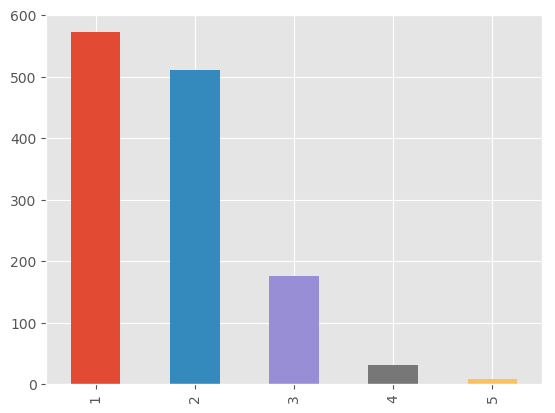

In [191]:
df_all_scaled['homicide_rank'].value_counts().plot.bar()
plt.show()

#### SMOTE

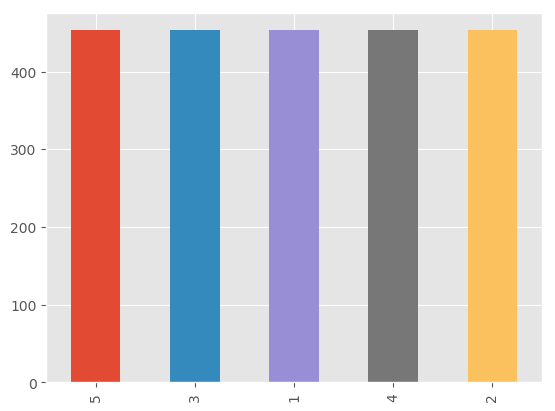

In [192]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X = df_all_scaled[df_all_scaled.columns[8:-1]]
y = df_all_scaled['homicide_rank']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2)

sm = SMOTE(random_state = 33)
X_train, y_train = sm.fit_sample(X_train, y_train)

# for i in range(3):
#     sm = SMOTE(random_state = 33)
#     X_train_new, y_train_new = sm.fit_sample(X_train, y_train)
#     X_train = np.r_[X_train, X_train_new]
#     y_train = np.r_[y_train, y_train_new]
#     print(f'{(i+1) * 34}% Complete')

pd.Series(y_train).value_counts().plot.bar()
plt.show()

#### Find Most Important Features

In [193]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=100)
fit = bestfeatures.fit(X_train, y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']  #naming the dataframe columns
most_important_features = featureScores.nlargest(50, 'Score') 
most_important_features

,Specs,Score
169,minimum_age_q3,335.882028
175,permitting_process_q5,327.402989
38,criminals_q7,326.900833
102,drugs_and_alcohol_q2_handgun_possession,323.688500
214,other_q8,319.851048
174,permitting_process_q3,317.740567
285,domestic_violence_q5_handgun_possession_neighbors,317.192358
104,drugs_and_alcohol_q2_long_gun_possession,308.096154
311,domestic_violence_q12_neighbors,307.736046
325,drugs_and_alcohol_q2_handgun_possession_neighbors,296.302719


In [194]:
# predictors = []

# for predictor in list(most_important_features['Specs']):
#     if 'neighbor' not in predictor:
#         predictors.append(predictor)

predictors = list(most_important_features['Specs'])

i=1
while i==1:
    f = 'homicide_rate~+'
    for predictor in predictors:
        f += f'+{predictor}'
    model = smf.ols(formula=f, data=df_all_scaled).fit()
    param_drop = None
    highest_p_val = .05
    for param, pval in zip(predictors, model.pvalues[1:]):
        if pval > highest_p_val:
            highest_p_val = pval
            param_drop = param
    if param_drop == None:
        i=0
    else:
        predictors.remove(param_drop)


print(model.summary())
print('\n\n\n')

                            OLS Regression Results                            
Dep. Variable:          homicide_rate   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     40.54
Date:                Sat, 31 Aug 2019   Prob (F-statistic):          6.51e-162
Time:                        15:29:25   Log-Likelihood:                 959.46
No. Observations:                1300   AIC:                            -1857.
Df Residuals:                    1269   BIC:                            -1697.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

### Machine Learning Algorithms
#### Dimensionality Reduction with Primary Component Analysis (PCA)

In [195]:
from sklearn.decomposition import PCA

# X = df_all_scaled[most_important_features['Specs']]
X = df_all_scaled[predictors]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2)

print('Generating Synthetic Data\n-------------------------')

sm = SMOTE(random_state = 33)
X_train, y_train = sm.fit_sample(X_train, y_train)

# for i in range(3):
#     sm = SMOTE(random_state = 33)
#     X_train_new, y_train_new = sm.fit_sample(X_train, y_train)
#     X_train = np.r_[X_train, X_train_new]
#     y_train = np.r_[y_train, y_train_new]
#     print(f'{(i+1) * 34}% Complete')

print(f'-------------------------\nTrain Sample Size: {y_train.shape[0]}')

pca = PCA(n_components=.99, random_state=123)
feat_pca = pca.fit_transform(X_train)
n_feat = feat_pca.shape[1]

print(f'\nNumber of Features: {n_feat}')
print(f'Cumulative Sum Variance:\n{np.cumsum(pca.explained_variance_ratio_)}')

Generating Synthetic Data
-------------------------
-------------------------
Train Sample Size: 2265

Number of Features: 24
Cumulative Sum Variance:
[0.25342023 0.37903737 0.47620906 0.55224476 0.61197222 0.65803586
 0.7008217  0.74319259 0.78043006 0.81057693 0.83685968 0.85828878
 0.87934395 0.89705146 0.91299509 0.92690481 0.93853345 0.94928252
 0.95887674 0.96791976 0.9764606  0.98339051 0.98911676 0.99265309]


#### Decision Tree Pipeline

In [196]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

tree_pipe = Pipeline([('pca', PCA(n_components=n_feat, random_state=123)), 
                      ('clf', DecisionTreeClassifier(random_state=123))])

tree_grid = [{'clf__criterion': ['gini', 'entropy'],
              'clf__max_depth': list(range(1, 11, 2)), 
              'clf__min_samples_split': [i/100 for i in range(5, 96, 10)], 
              'clf__min_samples_leaf': list(range(1, 11, 2))}]

acc_meas = 'balanced_accuracy'
tree_gridsearch = GridSearchCV(estimator = tree_pipe, 
                               param_grid = tree_grid, 
                               scoring = acc_meas, 
                               cv=5, verbose = 1, 
                               return_train_score = True)

tree_gridsearch.fit(X_train, y_train)
print(f'Best Decision Tree Pipeline Score: {tree_gridsearch.best_score_}')
print(f'Parameters: {tree_gridsearch.best_params_}')

results = {'Pipeline':   ['Decision Tree'], 
           'Top Score':  [tree_gridsearch.best_score_], 
           'Parameters': [tree_gridsearch.best_params_]}

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Decision Tree Pipeline Score: 0.7867549668874172
Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 9, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 0.05}


[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:   42.6s finished


#### Logistic Regression Pipline

In [197]:
from sklearn.linear_model import LogisticRegression

logreg_pipe = Pipeline([('pca', PCA(n_components=n_feat, random_state=123)), 
                        ('logreg', LogisticRegression(random_state=123))])

logreg_grid = [{'logreg__C': [.001, 0.01, 0.1, 1, 10, 100, 1000], 
                'logreg__penalty': ['l1', 'l2']}]

logreg_gridsearch = GridSearchCV(estimator = logreg_pipe, 
                                 param_grid = logreg_grid, 
                                 scoring = acc_meas, 
                                 cv = 5, verbose = 1, return_train_score = True)

logreg_gridsearch.fit(X_train, y_train)

print(f'Best Logistic Regression Pipeline Score: {logreg_gridsearch.best_score_}')
print(f'Parameters: {logreg_gridsearch.best_params_}')

results['Pipeline'].append('Logistic Regression')
results['Top Score'].append(logreg_gridsearch.best_score_)
results['Parameters'].append(logreg_gridsearch.best_params_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   38.4s finished


Best Logistic Regression Pipeline Score: 0.7333333333333333
Parameters: {'logreg__C': 100, 'logreg__penalty': 'l1'}


#### Support Vector Machine Pipeline

In [198]:
from sklearn.svm import SVC

svm_pipe = Pipeline([('pca', PCA(n_components=n_feat, random_state=123)), 
                     ('svm', SVC(random_state=123))])

svm_grid = [{'svm__kernel': ['linear'],
             'svm__C': [.1, 1, 10], 
             'svm__degree': list(range(1, 11, 2))}, 
            
            {'svm__kernel': ['rbf'],
             'svm__C': [.1, 1, 10],
             'svm__degree': list(range(1, 11, 2)),
             'svm__gamma': [0.001, .01, 'auto']}
           ]

svm_gridsearch = GridSearchCV(estimator = svm_pipe, 
                              param_grid = svm_grid, 
                              scoring = acc_meas, 
                              cv = 5, verbose = 1, return_train_score = True)

svm_gridsearch.fit(X_train, y_train)

print(f'Best SVM Pipeline Score: {svm_gridsearch.best_score_}')
print(f'Parameters: {svm_gridsearch.best_params_}')

results['Pipeline'].append('Support Vector Machine')
results['Top Score'].append(svm_gridsearch.best_score_)
results['Parameters'].append(svm_gridsearch.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best SVM Pipeline Score: 0.8004415011037528
Parameters: {'svm__C': 10, 'svm__degree': 1, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.2min finished


#### Random Forest Pipeline

In [199]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline([('pca', PCA(n_components=n_feat, random_state=123)), 
                    ('rf', RandomForestClassifier(random_state=123))])

rf_grid = [{'rf__criterion': ['gini', 'entropy'],
            'rf__max_depth': list(range(1, 11, 2)), 
            'rf__min_samples_split': [i/100 for i in range(5, 96, 10)], 
            'rf__min_samples_leaf': list(range(1, 11, 2))}]

rf_gridsearch = GridSearchCV(estimator = rf_pipe, 
                             param_grid = rf_grid, 
                             scoring = acc_meas, 
                             cv = 5, verbose = 1, return_train_score = True)

rf_gridsearch.fit(X_train, y_train)

print(f'Best Random Forest Pipeline Score: {rf_gridsearch.best_score_}')
print(f'Parameters: {rf_gridsearch.best_params_}')

results['Pipeline'].append('Random Forest')
results['Top Score'].append(rf_gridsearch.best_score_)
results['Parameters'].append(rf_gridsearch.best_params_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best Random Forest Pipeline Score: 0.8423841059602649
Parameters: {'rf__criterion': 'gini', 'rf__max_depth': 9, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 0.05}


[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:  1.0min finished


#### Adaboost Pipeline

In [200]:
from sklearn.ensemble import AdaBoostClassifier

ada_pipe = Pipeline([('pca', PCA(n_components=n_feat, random_state=123)), 
                     ('ada', AdaBoostClassifier(random_state=123))])


ada_grid = [{'ada__learning_rate': [i/100 for i in range(1, 100)]}]

ada_gridsearch = GridSearchCV(estimator = ada_pipe, 
                              param_grid = ada_grid, 
                              scoring = acc_meas, 
                              cv = 5, verbose = 1, return_train_score = True)

ada_gridsearch.fit(X_train, y_train)

print(f'Best Adaboost Pipeline Score: {ada_gridsearch.best_score_}')
print(f'Parameters: {ada_gridsearch.best_params_}')

results['Pipeline'].append('Adaboost')
results['Top Score'].append(ada_gridsearch.best_score_)
results['Parameters'].append(ada_gridsearch.best_params_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=1)]: Done 495 out of 495 | elapsed:  1.9min finished


Best Adaboost Pipeline Score: 0.5434878587196468
Parameters: {'ada__learning_rate': 0.35}


#### XGBoost Pipeline

In [201]:
import xgboost as xgb

acc_meas = 'balanced_accuracy'

xgb_pipe = Pipeline([('pca', PCA(n_components=n_feat, random_state=123)), 
                     ('xgb', xgb.XGBClassifier())])

xgb_grid = {'xgb__learning_rate': [i/100 for i in range(25, 41, 5)],
            'xgb__max_depth': [9],
            'xgb__min_child_weight': [2],
            'xgb__subsample': [i/100 for i in range(50, 100, 10)],
            'xgb__n_estimators': [75, 90, 100]}

xgb_gridsearch = GridSearchCV(estimator = xgb_pipe, 
                              param_grid = xgb_grid, 
                              scoring = acc_meas, 
                              cv = 5, verbose = 1, return_train_score = True)

xgb_gridsearch.fit(X_train, y_train)

print(f'Best XGBoost Pipeline Score: {xgb_gridsearch.best_score_}')
print(f'Parameters: {xgb_gridsearch.best_params_}')

results['Pipeline'].append('XGBoost')
results['Top Score'].append(xgb_gridsearch.best_score_)
results['Parameters'].append(xgb_gridsearch.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  8.7min finished


Best XGBoost Pipeline Score: 0.9152317880794701
Parameters: {'xgb__learning_rate': 0.35, 'xgb__max_depth': 9, 'xgb__min_child_weight': 2, 'xgb__n_estimators': 75, 'xgb__subsample': 0.7}


In [202]:
from sklearn.metrics import accuracy_score
y_hat_test = xgb_gridsearch.predict(X_test)
accuracy_score(y_test, y_hat_test)

0.8423076923076923

#### Model Results
**Best Train:** 92% <br>
**Best Test:** 85%

In [203]:
results_df = pd.DataFrame.from_dict(results)
results_df

,Pipeline,Top Score,Parameters
0,Decision Tree,0.786755,"{'clf__criterion': 'gini', 'clf__max_depth': 9..."
1,Logistic Regression,0.733333,"{'logreg__C': 100, 'logreg__penalty': 'l1'}"
2,Support Vector Machine,0.800442,"{'svm__C': 10, 'svm__degree': 1, 'svm__gamma':..."
3,Random Forest,0.842384,"{'rf__criterion': 'gini', 'rf__max_depth': 9, ..."
4,Adaboost,0.543488,{'ada__learning_rate': 0.35}
5,XGBoost,0.915232,"{'xgb__learning_rate': 0.35, 'xgb__max_depth':..."


In [204]:
from sklearn.metrics import classification_report

models = [tree_gridsearch, logreg_gridsearch, svm_gridsearch, rf_gridsearch, ada_gridsearch, xgb_gridsearch]
for name, mod in zip(results_df['Pipeline'], models):
    y_hat_test = mod.predict(X_test)
    score = accuracy_score(y_test, y_hat_test)
    
    print(f'{name} Accuracy: {score*100:.2f}%')
    print(f'---------Classification Report---------\n{classification_report(y_test, y_hat_test)}\n')
    
# accuracy_score(y_test, y_hat_test)

Decision Tree Accuracy: 75.38%
---------Classification Report---------
              precision    recall  f1-score   support

           1       0.82      0.80      0.81       119
           2       0.77      0.75      0.76       101
           3       0.57      0.64      0.60        33
           4       0.43      0.60      0.50         5
           5       1.00      0.50      0.67         2

   micro avg       0.75      0.75      0.75       260
   macro avg       0.72      0.66      0.67       260
weighted avg       0.76      0.75      0.76       260


Logistic Regression Accuracy: 68.46%
---------Classification Report---------
              precision    recall  f1-score   support

           1       0.84      0.72      0.78       119
           2       0.72      0.71      0.72       101
           3       0.38      0.45      0.42        33
           4       0.25      0.80      0.38         5
           5       0.33      0.50      0.40         2

   micro avg       0.68      0.68   

### Neural Networks
#### Baseline Model

In [205]:
from keras import models, layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam, SGD

n =len(predictors)


model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(n, )))
model.add(layers.Dense(512, activation='tanh'))
model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dropout(.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='tanh'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer=Adam(lr=.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Create Checkpoints & Stopping Parameters
checkpoints_path = f'model.hdf5'

checkpoint = ModelCheckpoint(checkpoints_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True)#, 
#                              mode='min')

early_stopping = EarlyStopping(monitor='val_loss', 
#                                mode='min', 
                               patience=10)

callbacks = [checkpoint, early_stopping]

history = model.fit(X_train,
                    y_train,
                    epochs=1000,
                    batch_size=256, 
                    validation_split=.3,  
                    callbacks=callbacks)

results = model.evaluate(X_test, y_test)
results

Train on 1585 samples, validate on 680 samples
Epoch 1/1000
1585/1585 [==============================] - 1s 519us/step - loss: 1.4233 - acc: 0.3697 - val_loss: 2.5740 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 2.57399, saving model to model.hdf5
Epoch 2/1000
1585/1585 [==============================] - 0s 76us/step - loss: 0.9449 - acc: 0.6164 - val_loss: 2.7063 - val_acc: 0.1162

Epoch 00002: val_loss did not improve from 2.57399
Epoch 3/1000
1585/1585 [==============================] - 0s 71us/step - loss: 0.7647 - acc: 0.6852 - val_loss: 2.6257 - val_acc: 0.1500

Epoch 00003: val_loss did not improve from 2.57399
Epoch 4/1000
1585/1585 [==============================] - 0s 79us/step - loss: 0.6746 - acc: 0.7243 - val_loss: 2.2779 - val_acc: 0.2206

Epoch 00004: val_loss improved from 2.57399 to 2.27790, saving model to model.hdf5
Epoch 5/1000
1585/1585 [==============================] - 0s 75us/step - loss: 0.5965 - acc: 0.7546 - val_loss: 1.9677 - val_acc: 0.

[0.5095854481825461, 0.8653846153846154]

In [62]:
# y_hat_test = model.predict(X_test)
# score = accuracy_score(y_test, y_hat_test)

# print(f'Neural Network Accuracy: {score*100:.2f}%')
# print(f'---------Classification Report---------\n{classification_report(y_test, y_hat_test)}\n')

In [63]:
np.array(y_train)

array([2, 2, 2, ..., 5, 5, 5])